Link for downloading the datasets (`mushrooms_ohe.csv` and `mushrooms_ohe_less.csv`):
https://drive.google.com/drive/folders/1tliMkryQ5qwOA4N7Qvzk-XwVazVZZtBd?usp=sharing

In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import chi2, SelectKBest, VarianceThreshold
from sklearn.metrics import (accuracy_score, auc, classification_report, confusion_matrix,
    f1_score, make_scorer, roc_curve, roc_auc_score, precision_score, recall_score)
from sklearn.model_selection import (cross_val_score, cross_validate, train_test_split,
    GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold)
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import CategoricalNB
from numpy import mean, std

## Functions definition

In [37]:
def get_metrics_clf(y_test, y_probs, th=0.5, name_col='model'):
    perf = pd.DataFrame(
        [   th,
            np.round(precision_score(y_test, (y_probs > th), pos_label=0), 3),
            np.round(recall_score(y_test, (y_probs > th), pos_label=0), 3),
            np.round(f1_score(y_test, (y_probs > th), pos_label=0), 3),
            np.round(accuracy_score(y_test, (y_probs > th)), 3),
            np.round(roc_auc_score(y_test, y_probs), 3)
        ],
        index=['Threshold','Precision', 'Recall', 'F1', 'Accuracy', 'AUC'],
        columns=[name_col]
    )

    return perf

In [38]:
def get_roc_curve_plot_new(y_test, y_probs, legend_model='Model', multiple=False):
    color_line = ['skyblue', 'green', 'orange', 'yellow', 'pink']

    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

    # plot the roc curve for the model
    if not multiple:
        if type(y_probs[0]) == pd.core.series.Series:
            return print("If you want to display more prediction at the same time you have to set parameter 'multiple=True'")
        else:
            m_fpr, m_tpr, _ = roc_curve(y_test, y_probs)
            plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill', color='red', linewidth=0.75)
            plt.plot(m_fpr, m_tpr, label=legend_model, color=color_line[0], linewidth=0.75)      
    else:
        plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill', color='red', linewidth=0.75)
        for i in range(len(y_probs)):
            m_fpr, m_tpr, _ = roc_curve(y_test, y_probs[i])
            plt.plot(m_fpr, m_tpr, label=legend_model[i], color=color_line[i], linewidth=0.75)

    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.legend(loc=4)
    plt.rcParams["figure.figsize"] = (10, 10)
    plt.show()

This function ```report``` is used for visualizing the results of the cross validation performed with grid search. The results are sorted from the best to the worst on the mean accuracy validation test score.

In [39]:
def report_cv(results, n_top=7):
    '''Report of cross validation results.'''
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Mean validation score: {0:.5f} (std: {1:.5f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}\n".format(results['params'][candidate]))

These two functions are used for computing the prediction of a model over a training and test set, and for visualizing the results of those predictions.

In [40]:
'''Functions for prediction and prediction results.'''

def predict(model, train_set, test_set):
    train_pred = model.predict(train_set)
    test_pred = model.predict(test_set)
    return train_pred, test_pred

def print_scores(phase, label, pred):
    print(phase)
    conf_matrix = confusion_matrix(label, pred, labels=[0, 1])
    sns.heatmap(conf_matrix, annot=True, fmt='g')
    print(classification_report(label, pred))

The functions ```train_knn``` and ```train_svm``` perform the model selection with a full and randomized grid search, respectively, and return the predictions of the best model.

In ```train_knn``` the best value for ```n_neighbors``` is chosen to be the largest one with the maximum accuracy in validation set; we did this for a better generalization of the model.

In [41]:
scoring = {"Recall on class 0": make_scorer(accuracy_score, pos_label=0)}

def train_knn(params, train_set, test_set, train_label):
    # Grid search with report.
    print('Performing grid search...')
    grid_search = GridSearchCV(
        KNeighborsClassifier(),
        params,
        n_jobs=-1,
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1),
        scoring=make_scorer(recall_score, pos_label=0)#make_scorer(accuracy_score)
    ).fit(train_set, train_label)
    report_cv(grid_search.cv_results_)

    # Find best parameters.
    new_results = zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score'])
    sorted_scores = list(reversed(sorted(new_results, key=lambda x: x[1])))
    best_score, best_pos, best_k = sorted_scores[0][1], 0, sorted_scores[0][0]['n_neighbors']
    for i, (params, score) in enumerate(sorted_scores):
        if score < best_score:
            break
        if params['n_neighbors'] > best_k:
            best_k = params['n_neighbors']
            best_pos = i
    print(sorted_scores[best_pos])
    
    print('Training with best hyperparameters...')
    knn = KNeighborsClassifier(**sorted_scores[best_pos][0]).fit(train_set, train_label)
    print('Model evaluation cross validation on accuracy...')
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    print(round(np.mean(cross_val_score(knn, train_set, train_label, scoring=make_scorer(accuracy_score), cv=cv, n_jobs=-1, error_score='raise')), 3))

    # Prediction on test set.
    return predict(knn, train_set, test_set), knn

In [42]:
def train_svm(params, train_set, test_set, train_label, n_iter=5):
    # Grid search with report.
    print('Performing grid search...')
    grid_search = RandomizedSearchCV(
        SVC(),
        params,
        n_iter=n_iter,
        random_state=126,
        n_jobs=-1,
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1),
        scoring = make_scorer(recall_score, pos_label=0)  # make_scorer(accuracy_score)
    ).fit(train_set, train_label)
    report_cv(grid_search.cv_results_)

    print('Training with best hyperparameters...')
    svm = SVC(**grid_search.best_params_).fit(train_set, train_label)

    print('Model evaluation cross validation on accuracy...')
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    print(round(np.mean(cross_val_score(svm, train_set, train_label, scoring=make_scorer(accuracy_score), cv=cv, n_jobs=-1, error_score='raise')), 3))

    # Prediction on test set.
    return predict(svm, train_set, test_set), svm

```get_models``` and ```evaluate_model``` return the models trained with the RFE with a number of features from 2 to a determined number. Then the models are evaluated on the recall of the poisonous class because our goal is to select a subset of features that reduce as much as a possible the number of poisonous mushrooms that are classified as edibile.

In [43]:
def get_models(n_features_to_select):
	'''Get a list of models to evaluate.'''
	models = {}
	for i in range(2, n_features_to_select+1):
		rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
		model = DecisionTreeClassifier()
		models[str(i)] = Pipeline(steps=[('s', rfe), ('m', model)])
	return models


def evaluate_model(model, X, y):
	'''Evaluate a give model using cross-validation.'''
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scorer = make_scorer(recall_score, pos_label=0)  # Recall on class 0 (poisonous)
	return cross_val_score(model, X, y, scoring=scorer, cv=cv, n_jobs=-1, error_score='raise')


def get_models_fra(clf, max_features=12, params=dict()):
	models = dict()
	for i in range(2, max_features):
		rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
		model = clf
		params['random_state'] = 42
		model.set_params(**params)

		models[str(i)] = Pipeline(steps=[('s', rfe), ('m', model)])
	return models


def evaluate_model_fra(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
	scorer = make_scorer(recall_score, pos_label=0)
	scores = cross_val_score(model, X, y, scoring= scorer, cv=cv, n_jobs=-1, error_score='raise')
	return scores

The first function just prints a boxplot of the evaluation of the models obtained with the RFE, while the second prints the features that have been selected by the RFE process.

In [44]:
def best_number_RFE_features(train_set, test_set, max_features=8):
    models = get_models(max_features)
    # evaluate the models and store results
    results, names = [], []
    for name, model in models.items():
        scores = evaluate_model(model, train_set, train_label)
        results.append(scores)
        names.append(name)
        print('%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    # plot model performance for comparison
    plt.boxplot(results, labels=names, showmeans=True)
    plt.xlabel('number of features', fontsize=20)
    plt.ylabel('scores', fontsize=20)
    plt.grid(alpha=0.2)
    plt.show()

def get_n_feature_rfe(df, clf, max_features= 12, params = dict()):
	# get the data and the models to evaluate
	x_train, x_test, y_train, y_test = test_split(df)
	models = get_models_fra(clf,max_features = max_features, params= params)

	# evaluate the models and store results
	results, names = list(), list()
	for name, model in models.items():
		scores = evaluate_model_fra(model, x_train, y_train)
		results.append(scores)
		names.append(name)
		print('%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
	
	# plotting results rfe
	plt.figure(figsize=(7, 7), dpi=80)
	plt.boxplot(results, labels=names, showmeans=True)
	plt.xlabel('number of features', fontsize=5)
	plt.xlim(right = max_features)
	plt.ylabel('scores', fontsize=10)
	plt.grid(alpha=0.2)
	plt.show()

def get_name_cols_rfe(df, n_features, x_train, y_train,):

  # define RFE
  rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=n_features)

  # fit RFE
  rfe.fit(x_train, y_train)

  # summarize all features
  for i in range(x_train.shape[1]):
    if (rfe.support_[i]):
      print('Column: %s, Selected %s, Rank: %.3f' % (df.columns[i+1], rfe.support_[i], rfe.ranking_[i]))

def test_split(df, test_size= 0.3, labels= 'edible' ):

  cols = [col for col in df.columns if col != labels ]
  X = df[cols].values
  Y= df['edible'].values

  x_train, x_test, y_train, y_test = train_test_split( X, Y, test_size= test_size, random_state=0)

  return x_train, x_test, y_train, y_test


def eval_rfe_model(df,clf,n_features, params= None):

  x_train, x_test, y_train, y_test = test_split(df)  

  # setting the pipeline
  rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=n_features)
  clf = clf
  if params == None:
    params = dict()
    params['random_state']= 42
    clf.set_params(**params)
  
  else:
    params['random_state']= 42
    clf.set_params(**params)
  pipeline = Pipeline(steps=[('s', rfe), ('m', clf)])

  # cross-validation 
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2 , random_state=42)
  scorer = make_scorer(recall_score, pos_label=0)
  n_scores = cross_val_score(pipeline, x_train, y_train, scoring= scorer, cv=cv, n_jobs=-1)
  print('recall: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

  # prediction on test-set
  pipeline.fit(x_test, y_test)
  y_pred = pipeline.predict(x_test)

  # evaluation on test-set
  report(y_pred, y_test)

  return y_test, y_pred


def RFE_best_features(select=8):
    rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=select)
    rfe.fit(train_set, train_label)
    # summarize all features
    selected = []
    for i in range(train_set.shape[1]):
        if rfe.support_[i]:
            selected.append(i)
            print('Column: %s, Selected %s, Rank: %.3f' % (train_set.columns[i], rfe.support_[i], rfe.ranking_[i]))
    return selected

In [45]:
def plot_roc(y_test, y_pred):
    # plotting roc-auc curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % (auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=20)
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=22)
    plt.legend(loc="lower right", fontsize=14, frameon=False)
    plt.show()

In [46]:
def cramers_V(var1,var2):
    '''This function is used in order to make the Chramer's V matrix.'''
    crosstab = np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))  
    stat = chi2_contingency(crosstab)[0]
    obs = np.sum(crosstab)  
    mini = min(crosstab.shape)-1  
    return (stat/(obs*mini))

In [47]:
def make_model(clf, x_train, y_train, x_test, params=dict()):

  clf= clf
  params['random_state'] = 42
  clf.set_params(**params)

  # cross-validation
  scorer = { 'accuracy' : make_scorer(accuracy_score),
            'recall': make_scorer(recall_score, pos_label=0)}
  cv = RepeatedStratifiedKFold(n_splits= 5, random_state= 42)
  scores = cross_validate(clf, x_train, y_train, cv= cv, scoring = scorer)
  print("CV-scores: %0.2f recall with a standard deviation of %0.2f" % (scores['test_recall'].mean(), scores['test_recall'].std()))
  print("CV-scores: %0.2f accuracy with a standard deviation of %0.2f" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std()))
  print()

  # fit the model to data and get predictions and trained model
  clf.fit(x_train, y_train)
  return clf, clf.predict(x_test)

def report(y_pred, y_test):

  print('results on test set:')
  print('Accuracy %s' % accuracy_score(y_test, y_pred))
  print('F1-score %s' % f1_score(y_test, y_pred, average=None))
  print(classification_report(y_test, y_pred))
  print('Confusion Matrix:')
  print(confusion_matrix(y_test, y_pred))
  print()

  # plotting roc-auc curve
  fpr, tpr, _ = roc_curve(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred)
  plt.figure(figsize=(8, 5))
  plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % (auc))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate', fontsize=20)
  plt.ylabel('True Positive Rate', fontsize=20)
  plt.tick_params(axis='both', which='major', labelsize=22)
  plt.legend(loc="lower right", fontsize=14, frameon=False)
  plt.show()

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
import os
os.chdir('/content/drive/MyDrive/BDA/')

#### We are going to analyze two versions of the mushrooms dataset: 
- the ```original dataset```: the original one, 
- the ```reduced dataset```: have been removed all the features that **might be hard/impossible to see or to determine** such as the odor, the root of the stalk, the color of the spores, the population, and the habitat.

For both of them, we are going to train a KNN, SVM, categorical NB, DT and RF models, with and without feature selection. The datasets are already one-hot encoded.

## Classification problem
Our goal is to find a model that is able to identify if a mushroom is edible or not.
For safety reason (since a mushroom can be deadly poisonous), the model to be acceptable should have 100% of recall for the poisonous class, so the number of false edible must be 0. In constrast, a model with a 100% precision on poisonous class is not required.


## Dummy classifier

In our baseline model all mushrooms are classified as poisonous.

In [50]:
mushrooms_ohe = pd.read_csv('mushrooms_ohe.csv', index_col=0)
label = mushrooms_ohe.pop('edible')

train_set, test_set, train_label, test_label = \
    train_test_split(
        mushrooms_ohe, label, stratify=label, test_size=0.3, random_state=42
    )

In [51]:
dummy = DummyClassifier(strategy='constant', constant=0).fit(train_set, train_label)
train_pred, test_pred = predict(dummy, train_set, test_set)

Train
              precision    recall  f1-score   support

           0       0.48      1.00      0.65      2741
           1       0.00      0.00      0.00      2945

    accuracy                           0.48      5686
   macro avg       0.24      0.50      0.33      5686
weighted avg       0.23      0.48      0.31      5686



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


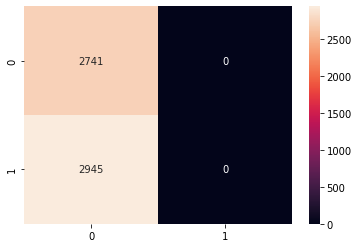

In [52]:
print_scores('Train', train_label, train_pred)

Test
              precision    recall  f1-score   support

           0       0.48      1.00      0.65      1175
           1       0.00      0.00      0.00      1263

    accuracy                           0.48      2438
   macro avg       0.24      0.50      0.33      2438
weighted avg       0.23      0.48      0.31      2438



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


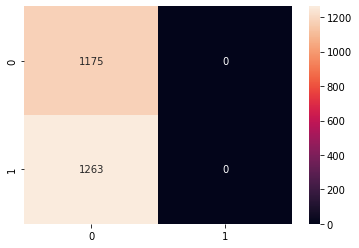

In [53]:
print_scores('Test', test_label, test_pred)

Summing up, the baseline metrics are the following:

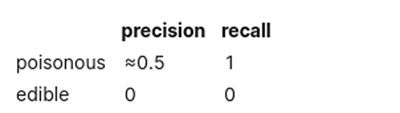

# Original dataset: KNN and SVM

First we load the dataset  previously one-hot encoded and we split it into train (70%) and test test (30%) in a stratified fashion such that each set contains approximately the same percentage of samples of each target class as the original set. 

In [54]:
mushrooms_ohe = pd.read_csv('mushrooms_ohe.csv', index_col=0)
label = mushrooms_ohe.pop('edible')

train_set, test_set, train_label, test_label = \
    train_test_split(
        mushrooms_ohe, label, stratify=label, test_size=0.3, random_state=42
    )

## Without feature selection

In the following section, we make classification using all the features. The perfomance of the models in this section will be compared with the ones with feature selection in order to establish the usefulness of FS, and establish the best models.  

###  K-Nearest Neighbors (KNN) 

We are finding the best KNN model through a full grid search with 2 repeated stratified 5-fold cross validation, in which the number of neighbors goes from 1 to 19 (higher numbers of neighbors tend to underfit). 

The cross validation is used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. Since we are interested in model with higher recall on poisonous class, the validation score is ```recall_score``` on poisonous class.

As algorithm, we decided to use ```auto``` because it will attempt to decide the most appropriate algorithm based on the values passed to fit method.
Since we have boolean features, the distance metric used is the ```JaccardDistance``` intended for boolean-valued vector spaces.

After hyperparameters tuning and model evaluation, the ```train_knn``` function trains the model on the whole train set with the best configuration parameters. 

After we trained the best model, we evaluate it on the accuracy to understand if the model has also good perfomance on the edible class.

We recall that it will be chosen the model with the best mean validation recall score on poisonous class, and the highest number of neighbors (if the performance is the same).


In the ```complete_recap``` dictionary we store the results of the predictions of each model trained on the complete dataset, for a final comparison.

In [55]:
# GridSearch parameters
params = {
    'n_neighbors': [x for x in range(1, 20, 2)],
    'algorithm': ['auto'],
    'metric': ['jaccard']
}

# GridSearchCV + Train model with best parameters
(train_pred, test_pred), knn = train_knn(params, train_set, test_set, train_label)

# store result of the predictions
complete_recap = {
    'no_fs': {
        'knn': (test_label, test_pred)
    },
    'fs': {
        'knn': None
    }
}

Performing grid search...
Mean validation score: 1.00000 (std: 0.00000)
Parameters: {'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 1}

Mean validation score: 1.00000 (std: 0.00000)
Parameters: {'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 3}

Mean validation score: 1.00000 (std: 0.00000)
Parameters: {'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 5}

Mean validation score: 0.99964 (std: 0.00109)
Parameters: {'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 7}

Mean validation score: 0.99945 (std: 0.00164)
Parameters: {'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 9}

Mean validation score: 0.99872 (std: 0.00183)
Parameters: {'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 11}

Mean validation score: 0.99854 (std: 0.00179)
Parameters: {'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 15}

Mean validation score: 0.99854 (std: 0.00179)
Parameters: {'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 17}

Mean valida

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Let's see the results of the classification with 5 neighbors and Jaccard similarity of the boolean vectors. Given the results of model evaluation, the risk is to have poor perfomance on edible class but this is an acceptable risk if we look for safety.


Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2741
           1       1.00      1.00      1.00      2945

    accuracy                           1.00      5686
   macro avg       1.00      1.00      1.00      5686
weighted avg       1.00      1.00      1.00      5686



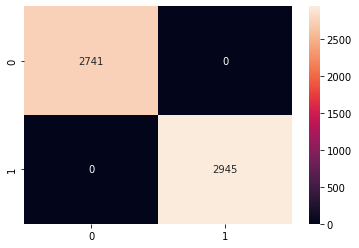

In [56]:
print_scores('Train', train_label, train_pred)

The trained model has perfect scores in terms of precision and recall for both classes on train set. Given the results of gridsearch with cross validation, we expect this kind of results. The k-fold cross validation score does not indicate overfitting situation. 

We apply the KNN model on the test set.

Test
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1175
           1       1.00      1.00      1.00      1263

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



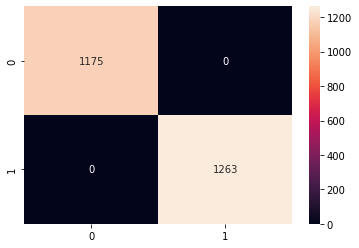

In [57]:
print_scores('Test', test_label, test_pred)

The performance in terms of precision and recall for both classes are perfect. This means that the model with this configuration is able to correctly classify all the instances. The model is not overfitting.

NOTE: KNN is able to have a perfect classifcation even with a smaller training set.

### Support Vector Machines (SVMs)

In this section, we are going to apply SVM to the original dataset without features selection.

For SVM we are just running 10 iterations of RandomizedGridSearch with repeated stratified 5-fold cross validation on ```recall_score``` on poisonous class, used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters, for time reasons. In the grid search there are different values of kernels and the regularization parameter.

After hyperparameters tuning and model evaluation, the ```train_svm``` function trains the model on the whole train set with the best configuration parameters retrieved by grid search. 


After we trained the best model, we evaluate it on the accuracy to understand if the model has also good perfomance on edible class.

Then computes the prediction of model for train and test set. Below are shown the results.

In [59]:
params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
          'gamma' : ['scale'],
          'C'     : [0.001, 0.01, 0.1, 0.5, 1],
}
n_iter_search = 10
(train_pred, test_pred), _ = train_svm(params, train_set, test_set, train_label, n_iter=n_iter_search)
complete_recap['no_fs']['svm'] = (test_label, test_pred)

Performing grid search...
Mean validation score: 1.00000 (std: 0.00000)
Parameters: {'kernel': 'poly', 'gamma': 'scale', 'C': 0.5}

Mean validation score: 1.00000 (std: 0.00000)
Parameters: {'kernel': 'poly', 'gamma': 'scale', 'C': 1}

Mean validation score: 1.00000 (std: 0.00000)
Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 1}

Mean validation score: 1.00000 (std: 0.00000)
Parameters: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.5}

Mean validation score: 0.99891 (std: 0.00234)
Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 0.5}

Mean validation score: 0.99763 (std: 0.00201)
Parameters: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.1}

Mean validation score: 0.97410 (std: 0.00814)
Parameters: {'kernel': 'poly', 'gamma': 'scale', 'C': 0.01}

Training with best hyperparameters...
Model evaluation cross validation on accuracy...
1.0


Best parameters configuration: { 'kernel': 'poly', 'gamma': 'scale', 'C': 0.5}. Below the summary of the perfomance on train set.

Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2741
           1       1.00      1.00      1.00      2945

    accuracy                           1.00      5686
   macro avg       1.00      1.00      1.00      5686
weighted avg       1.00      1.00      1.00      5686



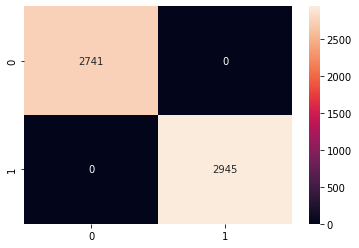

In [60]:
print_scores('Train', train_label, train_pred)

As KNN, we have obtained perfect results on train.

Test
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1175
           1       1.00      1.00      1.00      1263

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



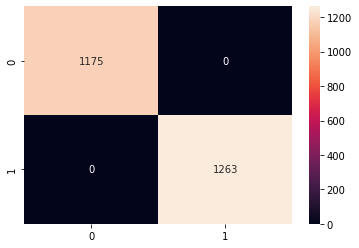

In [61]:
print_scores('Test', test_label, test_pred)

Also for SVM without feature selection, the predictions in test are perfect and even in this case the model is not overfitting.

**NOTE**: A possible reason for the perfect score is that there are several features in the dataset that have an imbalanced distribution on the target.

## With feature selection

In this section we are going to train the previous models only with the most important features detected via **Recursive Feature Elimination**, and we will see if the prediction scores stay perfect as before. If so, we can say that the feature selection worked well.

We are interested in feature selection/dimensionality reduction on sample sets, either to improve estimators’ accuracy scores or at least to boost their performance on very high-dimensional datasets.

The dataset is always the same one-hot encoded ```original dataset```.

Here we are splitting the dataset using different random_state, for performing the model selection with RFE.

In [62]:
train_set, test_set, train_label, test_label = \
    train_test_split(
        mushrooms_ohe, label, stratify=label, test_size=0.3, random_state=100
    )

The ```best_number_RFE_features``` function applies the RFE algorithm and model evaluation.
Given an external estimator (in this case a DecisionTree) that assigns weights to features, the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features until their number reaches ```max_features```. In practice, we cannot know the best number of features to select with RFE; so we tested different values.


We would like to select the best number of features by evaluating the recall scores of the models trained for RFE on the poisonous class since our goal is to have the minimum number as possible of false edible (ideally none of them). So the model trained by RFE with differt best number of features are evaluated using repeated 10-fold cross validation on ```recall score``` on poisonous class.

Below are plotted the box plot: on y axis, ```recall scores``` on poisonous class obtained with cross validation of the model and the best number of features with RFE on x axis.

2 0.831 (0.022)
3 0.899 (0.019)
4 0.960 (0.019)
5 0.983 (0.012)
6 0.995 (0.005)
7 0.997 (0.004)
8 0.998 (0.004)
9 0.998 (0.003)
10 0.998 (0.003)
11 0.999 (0.002)
12 1.000 (0.001)
13 1.000 (0.001)
14 1.000 (0.001)
15 1.000 (0.001)
16 1.000 (0.001)


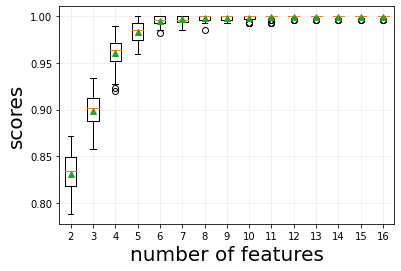

In [63]:
best_number_RFE_features(train_set, test_set, max_features=16)

Above 12 features, the accuracy stabilizes and there's no need of adding more features to the model. So we are going to select the best 12 for the next models.

The list below reports the best 12 features:

In [64]:
selected = RFE_best_features(select=12)

Column: bruises, Selected True, Rank: 1.000
Column: gill-size, Selected True, Rank: 1.000
Column: cap-shape_c, Selected True, Rank: 1.000
Column: cap-surface_g, Selected True, Rank: 1.000
Column: cap-color_y, Selected True, Rank: 1.000
Column: odor_n, Selected True, Rank: 1.000
Column: odor_p, Selected True, Rank: 1.000
Column: stalk-surface-below-ring_y, Selected True, Rank: 1.000
Column: stalk-color-above-ring_n, Selected True, Rank: 1.000
Column: stalk-color-below-ring_y, Selected True, Rank: 1.000
Column: spore-print-color_h, Selected True, Rank: 1.000
Column: spore-print-color_r, Selected True, Rank: 1.000


As expected from the Cramer's V matrix, the odor values, even if not all of them, are present among the most important features.

Now we reduce the train set and the test set with the best features.

In [65]:
train_set = train_set.iloc[:, selected]
test_set = test_set.iloc[:, selected]

With this dataset made of 12 most important features we are going to be training again the SVM and KNN models, and compare the results against the previous dataset.

###  K-Nearest Neighbors (KNN) 

The following block does exactly the same thing as before: grid search, model evaluation on recall_score on poisonous class, train the best model, but now on train set after applying RFE, and make prediction on train and test sets.

To better generalize, we select the model with high mean validation ```recall_score``` on poisonous class and highest number of neighbors.


After trained the best model, we evaluate it on the accuracy to understand if the model has also good perfomance on edible class.

In [66]:
params = {
    'n_neighbors': [x for x in range(1, 20, 2)],
    'algorithm': ['auto'],
    'metric': ['jaccard']
}

(train_pred, test_pred), _ = train_knn(params, train_set, test_set, train_label)
complete_recap['fs']['knn'] = (test_label, test_pred)

Performing grid search...
Mean validation score: 0.99964 (std: 0.00073)
Parameters: {'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 1}

Mean validation score: 0.99891 (std: 0.00089)
Parameters: {'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 3}

Mean validation score: 0.99891 (std: 0.00089)
Parameters: {'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 5}

Mean validation score: 0.99891 (std: 0.00089)
Parameters: {'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 7}

Mean validation score: 0.99891 (std: 0.00089)
Parameters: {'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 9}

Mean validation score: 0.99891 (std: 0.00089)
Parameters: {'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 11}

Mean validation score: 0.99836 (std: 0.00207)
Parameters: {'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 13}

Mean validation score: 0.99836 (std: 0.00207)
Parameters: {'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 15}

Mean valida

Below are reported the perfomance summary on train set.

Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2741
           1       1.00      1.00      1.00      2945

    accuracy                           1.00      5686
   macro avg       1.00      1.00      1.00      5686
weighted avg       1.00      1.00      1.00      5686



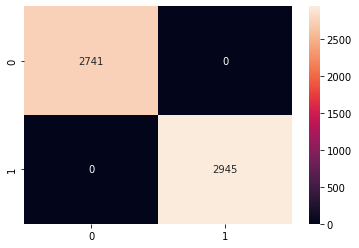

In [67]:
print_scores('Train', train_label, train_pred)

Like the original dataset, we have a perfect classification on train and we have boost the training process. The only difference is on mean the validation ```recall_score``` on poisonous class that is sliglty less than original dataset.

Test
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1175
           1       1.00      1.00      1.00      1263

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



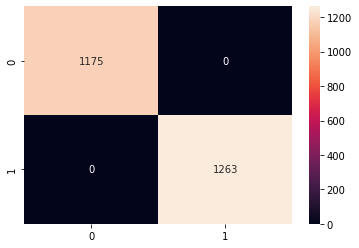

In [68]:
print_scores('Test', test_label, test_pred)

Again, the results with KNN are perfect, so the feature selection actually selected good features and we have reduced the dimensionality.

### Support Vector Machines (SVMs)

The following block does exactly the same thing of the previous on SVM: grid search, model evaluation on recall_score on poisonous class, train best model as we did before for SVM, but now on train set after applying RFE, and make predictions on train and test sets.

After trained the best model, we evaluate it on the accuracy to understand if the model has also good perfomance on edible class.

In [69]:
params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
          'gamma' : ['scale'],
          'C'     : [0.001, 0.01, 0.1, 0.5, 1]
}

n_iter_search = 10
(train_pred, test_pred), _ = train_svm(params, train_set, test_set, train_label, n_iter=n_iter_search)
complete_recap['fs']['svm'] = (test_label, test_pred)

Performing grid search...
Mean validation score: 1.00000 (std: 0.00000)
Parameters: {'kernel': 'poly', 'gamma': 'scale', 'C': 0.01}

Mean validation score: 0.99891 (std: 0.00089)
Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 0.5}

Mean validation score: 0.99891 (std: 0.00089)
Parameters: {'kernel': 'poly', 'gamma': 'scale', 'C': 1}

Mean validation score: 0.99891 (std: 0.00089)
Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 1}

Mean validation score: 0.99781 (std: 0.00363)
Parameters: {'kernel': 'poly', 'gamma': 'scale', 'C': 0.5}

Mean validation score: 0.99635 (std: 0.00336)
Parameters: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.5}

Mean validation score: 0.99635 (std: 0.00336)
Parameters: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.1}

Training with best hyperparameters...
Model evaluation cross validation on accuracy...
0.964


Below are reported the perfomance summary on train set.

Train
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      2741
           1       1.00      0.93      0.96      2945

    accuracy                           0.96      5686
   macro avg       0.97      0.97      0.96      5686
weighted avg       0.97      0.96      0.96      5686



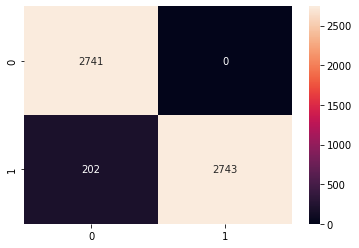

In [70]:
print_scores('Train', train_label, train_pred)

On train there are some of false poisonous and zero false edible that is the most important. Let's see the perfomance on test

Test
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1175
           1       1.00      0.93      0.96      1263

    accuracy                           0.96      2438
   macro avg       0.97      0.97      0.96      2438
weighted avg       0.97      0.96      0.96      2438



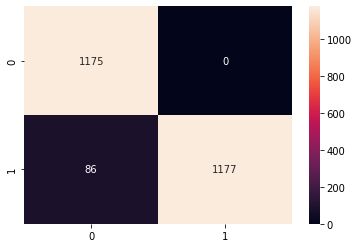

In [71]:
print_scores('Test', test_label, test_pred)

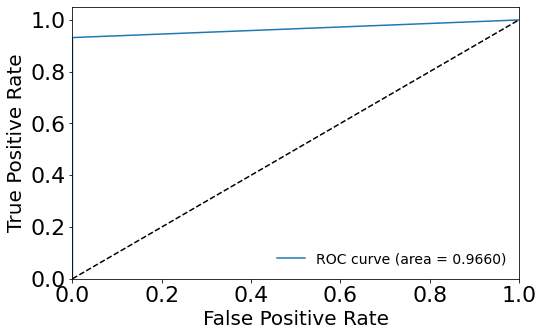

In [72]:
plot_roc(test_label, test_pred)

The model wrongly classifies only the edible mushrooms as poisonous. Our goal is reached since we have 100% recall on poisonous and we have improved the edible class classification.

# Reduced dataset: KNN and SVM

In this section we apply the same models KNN and SVM to a different dataset.
We recall int the ```reduced dataset``` have been removed all the features that **might be hard/impossible to see or to determine** such as the odor, the root of the stalk, the color of the spores, the population, and the habitat.

This could be a realistic scenario for people (expert or not) that go for for mushroom hunting and have to determine some features, e.g the habitat or population can be affecteded by mushrooms hunting and change or for image mushrooms recognition where some features could not be inferred.

Since we are removing some strong features such as odor, we expect to perform worse

The **dummy classifier** remains the same of the previous section.

In [73]:
# read new datasets
mushrooms_ohe = pd.read_csv('mushrooms_ohe_less.csv', index_col=0)
label = mushrooms_ohe.pop('edible')

train_set, test_set, train_label, test_label = \
    train_test_split(
        mushrooms_ohe, label, stratify=label, test_size=0.3, random_state=42
    )

## Without feature selection

In the following section, we make classification using all the features. The perfomance of the models in this section will be compared with the ones with feature selection in order to establish the usefulness of FS and establish the best models.  

###  K-Nearest Neighbors (KNN) 

We are using the same settings for hyperparameters tuning and evaluation of the previous section since both dataset have the same properties.

We recall that it will be chosen the model with the best mean validation ```recall_score``` on poisonous class, and the highest number of neighbors (if the performance is the same).

After trained the best model, we evaluate it on the accuracy to understand if the model has also a good perfomance on the edible class. 


In [74]:
params = {
    'n_neighbors': [x for x in range(1, 20, 2)],
    'algorithm': ['auto'],
    'metric': ['jaccard']
}

(train_pred, test_pred), _ = train_knn(params, train_set, test_set, train_label)

Performing grid search...
Mean validation score: 0.99544 (std: 0.00329)
Parameters: {'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 1}

Mean validation score: 0.99343 (std: 0.00307)
Parameters: {'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 3}

Mean validation score: 0.99106 (std: 0.00237)
Parameters: {'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 7}

Mean validation score: 0.99052 (std: 0.00453)
Parameters: {'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 5}

Mean validation score: 0.98924 (std: 0.00412)
Parameters: {'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 19}

Mean validation score: 0.98796 (std: 0.00504)
Parameters: {'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 9}

Mean validation score: 0.98760 (std: 0.00422)
Parameters: {'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 17}

({'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 1}, 0.9954406153191602)
Training with best hyperparameters...
Model evalu

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Below are reported the perfomance summary on train set.

Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2741
           1       1.00      1.00      1.00      2945

    accuracy                           1.00      5686
   macro avg       1.00      1.00      1.00      5686
weighted avg       1.00      1.00      1.00      5686



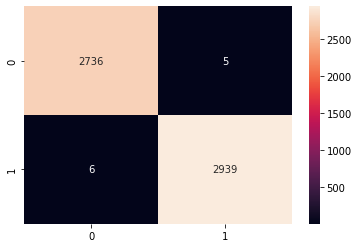

In [75]:
print_scores('Train', train_label, train_pred)

The result are almost perfect: as expected, the model makes small errors on both classes.

Below are reported the perfomance summary on test set.

Test
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1175
           1       1.00      1.00      1.00      1263

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



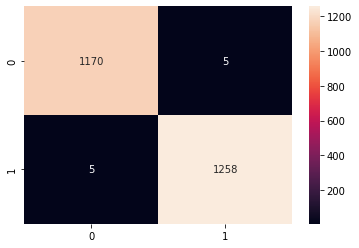

In [76]:
print_scores('Test', test_label, test_pred)

The result are still almost perfect. We can tell that the model is not overfitting.

We save the prediction results for this settings for recap in the last section.

In [77]:
reduced_recap = {
    'no_fs': {
        'knn': (test_label, test_pred)
    },
    'fs': {
        'knn': None
    }
}

### SVM

We are using the same settings for SVM hyperparameters tuning and evaluation of the previous sections since both dataset have the same properties.

In [78]:
params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
          'gamma' : ['scale'],
          'C'     : [0.001, 0.01, 0.1, 0.5, 1],
}
n_iter_search = 10
(train_pred, test_pred), _ = train_svm(params, train_set, test_set, train_label, n_iter=n_iter_search)
reduced_recap['no_fs']['svm'] = (test_label, test_pred)

Performing grid search...
Mean validation score: 0.99763 (std: 0.00183)
Parameters: {'kernel': 'poly', 'gamma': 'scale', 'C': 0.5}

Mean validation score: 0.99726 (std: 0.00234)
Parameters: {'kernel': 'poly', 'gamma': 'scale', 'C': 1}

Mean validation score: 0.99708 (std: 0.00203)
Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 1}

Mean validation score: 0.99489 (std: 0.00179)
Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 0.5}

Mean validation score: 0.97318 (std: 0.00653)
Parameters: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.5}

Mean validation score: 0.95604 (std: 0.00578)
Parameters: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.1}

Mean validation score: 0.84386 (std: 0.01723)
Parameters: {'kernel': 'poly', 'gamma': 'scale', 'C': 0.01}

Training with best hyperparameters...
Model evaluation cross validation on accuracy...
0.996


Below are reported the perfomance summary on train set.

Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2741
           1       1.00      1.00      1.00      2945

    accuracy                           1.00      5686
   macro avg       1.00      1.00      1.00      5686
weighted avg       1.00      1.00      1.00      5686



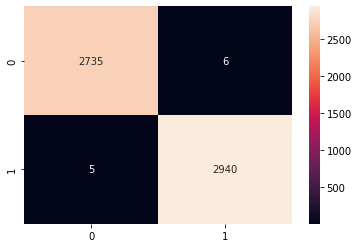

In [79]:
print_scores('Train', train_label, train_pred)

The result on the training set are almost perfect. As expected, the model makes small errors on both classes.

Below are reported the perfomance summary on test set.

Test
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1175
           1       1.00      1.00      1.00      1263

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



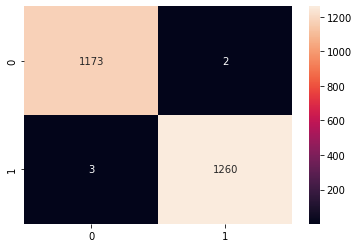

In [80]:
print_scores('Test', test_label, test_pred)

The result are almost perfect. The model makes small errors on both classes on test set. 

As expected, the ```reduced dataset without feature selection``` is slightly worse in terms of recall on poisonous class (the most important) in both model KNN and SVM with respect to the ```original one```. Despite the most correlated-class feature **odor** is missing, the perfomance are very good and this means that there other features that even if they are less correlated with the class, are able to almost correct classify the mushrooms.

If we are looking for simplicity and we are on a similar scenario of the ones described at the beggining of this section, then this model could be acceptable.

## With feature selection

As we did before, in this section we are going to find and use only the most important features detected via **Recursive Feature Elimination**.

We are interested in feature selection/dimensionality reduction on sample sets, either to improve estimators’ accuracy scores or at least to boost their performance on very high-dimensional datasets.

We split the dataset into train (70%) and test test (30%) in a stratified fashion such that each set contains approximately the same percentage of samples of each target class as the orignal set. 

In [81]:
train_set, test_set, train_label, test_label = \
    train_test_split(
        mushrooms_ohe, label, stratify=label, test_size=0.3, random_state=100
    )

As for the previous datatset, the ```best_number_RFE_features``` function applies the RFE algorithm and model evaluation.
Given an external estimator (in this case a DecisionTree) that assigns weights to features, the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features until their number reaches ```max_features```. In practice, we cannot know the best number of features to select with RFE; so we tested different values.

Also in this case, we would like to select the best number of features by evaluating the recall scores of the models trained for RFE on the poisonous class since our goal is to have the minimum number as possible of false edible (ideally none of them). So the model trained by RFE with differt best number of features are evaluated using repeated 10-fold cross validation on recall score.

Below are plotted the box plot: on y axis, recall scores obtained with cross validation of the model and the best number of features with RFE on x axis.

2 0.910 (0.015)
3 0.884 (0.018)
4 0.873 (0.022)
5 0.903 (0.020)
6 0.919 (0.020)
7 0.936 (0.016)
8 0.949 (0.012)
9 0.953 (0.012)
10 0.966 (0.011)
11 0.984 (0.006)
12 0.989 (0.006)
13 0.991 (0.005)


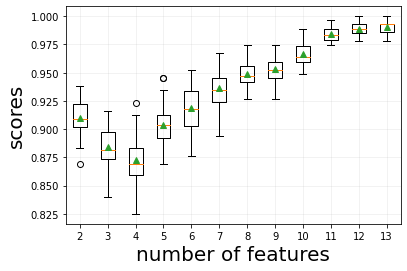

In [82]:
best_number_RFE_features(train_set, test_set, max_features=13)

After 10 features, the accuracy stabilizes and there's no need of adding more features to the model. So we are going to select the best 10 for the next models.

The list below reports the best 10 features:

In [83]:
selected = RFE_best_features(select=10)

Column: bruises, Selected True, Rank: 1.000
Column: gill-spacing, Selected True, Rank: 1.000
Column: gill-size, Selected True, Rank: 1.000
Column: stalk-shape, Selected True, Rank: 1.000
Column: cap-surface_f, Selected True, Rank: 1.000
Column: cap-surface_s, Selected True, Rank: 1.000
Column: cap-color_b, Selected True, Rank: 1.000
Column: stalk-surface-above-ring_k, Selected True, Rank: 1.000
Column: stalk-surface-below-ring_f, Selected True, Rank: 1.000
Column: ring-type_e, Selected True, Rank: 1.000


Below is prepared the train and test set after features selection.

In [84]:
train_set = train_set.iloc[:, selected]
test_set = test_set.iloc[:, selected]

###  K-Nearest Neighbors (KNN) 

In the following block is perfomed: gridsearchCv, model evaluation on recall_score on poisonous class, train best model as we did before for knn but now on train set after applying RFE and make prediction on train and test set.

To generalize better, we select the model with the highest mean validation accuracy and the highest number of neighbors.

After have trained the best model, we evaluate it on the accuracy to understand if the model has also good perfomance on edible class. 

In [85]:
params = {
    'n_neighbors': [x for x in range(1, 20, 2)],
    'algorithm': ['auto'],
    'metric': ['jaccard']
}

(train_pred, test_pred), _ = train_knn(params, train_set, test_set, train_label)
reduced_recap['fs']['knn'] = (test_label, test_pred)

Performing grid search...
Mean validation score: 0.97939 (std: 0.00875)
Parameters: {'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 11}

Mean validation score: 0.97939 (std: 0.00703)
Parameters: {'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 3}

Mean validation score: 0.97902 (std: 0.00945)
Parameters: {'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 13}

Mean validation score: 0.97866 (std: 0.00824)
Parameters: {'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 9}

Mean validation score: 0.97866 (std: 0.00920)
Parameters: {'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 1}

Mean validation score: 0.97720 (std: 0.00959)
Parameters: {'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 5}

Mean validation score: 0.97629 (std: 0.00969)
Parameters: {'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 15}

({'algorithm': 'auto', 'metric': 'jaccard', 'n_neighbors': 11}, 0.979386542220095)
Training with best hyperparameters...
Model eval

Below are reported the summary of the perfomance predictions on train set.

Train
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2741
           1       0.98      0.98      0.98      2945

    accuracy                           0.98      5686
   macro avg       0.98      0.98      0.98      5686
weighted avg       0.98      0.98      0.98      5686



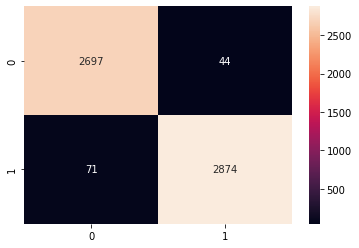

In [86]:
print_scores('Train', train_label, train_pred)

We got a mean accuracy score of 98% on model evaluation phase with cross validation, and also a lower recall on the poisonous class w.r.t previous models, and this means that some poisonous mushrooms are classified as edible, so we have false edible. Let's see the perfomance on test.

Test
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1175
           1       0.99      0.98      0.99      1263

    accuracy                           0.98      2438
   macro avg       0.98      0.98      0.98      2438
weighted avg       0.98      0.98      0.98      2438



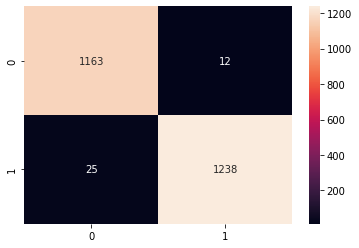

In [87]:
print_scores('Test', test_label, test_pred)

The test predictions reveals that this model tends to give false edible. This kind of results is expected because some strong features highly correlated with the class are removed, and we are in a scenario in which we have some missing information.

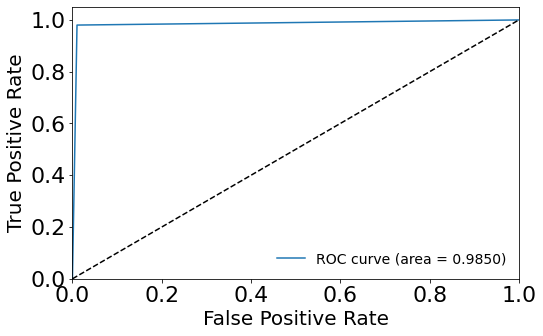

In [88]:
plot_roc(test_label, test_pred)

### SVM

The following block does exactly the same thing of the previous on SVM: RandomizedGridsearchCV, model evaluation, train best model but applying RFE.

In [89]:
params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
          'gamma' : ['scale'],
          'C'     : [0.001, 0.01, 0.1, 0.5, 1],
}
n_iter_search = 10
(train_pred, test_pred), _ = train_svm(params, train_set, test_set, train_label, n_iter=n_iter_search)
reduced_recap['fs']['svm'] = (test_label, test_pred)

Performing grid search...
Mean validation score: 0.97319 (std: 0.01135)
Parameters: {'kernel': 'poly', 'gamma': 'scale', 'C': 0.01}

Mean validation score: 0.97155 (std: 0.00632)
Parameters: {'kernel': 'poly', 'gamma': 'scale', 'C': 0.5}

Mean validation score: 0.97155 (std: 0.00632)
Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 0.5}

Mean validation score: 0.97155 (std: 0.00632)
Parameters: {'kernel': 'poly', 'gamma': 'scale', 'C': 1}

Mean validation score: 0.97155 (std: 0.00632)
Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 1}

Mean validation score: 0.93324 (std: 0.00509)
Parameters: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.5}

Mean validation score: 0.93324 (std: 0.00509)
Parameters: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.1}

Training with best hyperparameters...
Model evaluation cross validation on accuracy...
0.96


Below are reported the summary of the perfomance predictions on train set.

Train
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      2741
           1       0.98      0.95      0.97      2945

    accuracy                           0.97      5686
   macro avg       0.97      0.97      0.97      5686
weighted avg       0.97      0.97      0.97      5686



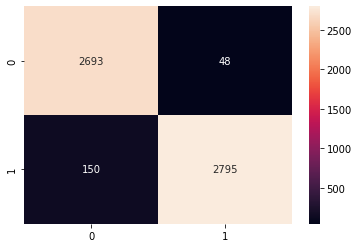

In [90]:
print_scores('Train', train_label, train_pred)

Same situation as KNN.

Test
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1175
           1       0.99      0.95      0.97      1263

    accuracy                           0.97      2438
   macro avg       0.97      0.97      0.97      2438
weighted avg       0.97      0.97      0.97      2438



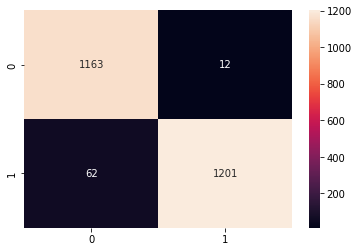

In [91]:
print_scores('Test', test_label, test_pred)

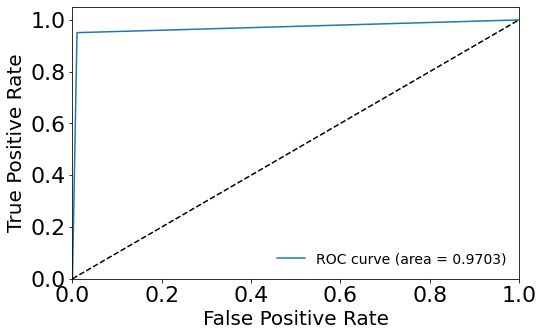

In [92]:
plot_roc(test_label, test_pred)

The test predictions reveals that this model tends to have false edible. This kind of results is expected because some strong features higly correlated with the class are removed and we are in a scenario in which we have some missing information.

The ```reduced dataset``` with feature selection is slightly worse in terms of recall on poisonous class (the most important) in both model KNN and SVM with respect to the ```reduced dataset without RFE```. Despite the most correlated-class feature **odor** is missing, the perfomances are very good and this means that there are other features that even if less correlated with the class, are able to almost correctly classify the mushrooms. 

Moreover these models tend also to wrongly classify much more edible mushrooms as poisonous. These results are acceptable because it is "safe" and our goal is to have a reasonable perfomance on edible class.

If we are looking for simplicity and we are on a similar scenario of the ones described at the beggining of this section, then these models could be acceptable.

# Original dataset: DT and RF

For these models, Decision tree and random forest, we proceed more or less in the same way as before. First we trained a model with default parameter and after that we did a hyperparameter tuning of that model. In this way we can compare the two version of the models (with default parameter and the optimezed version ) in terms of performance results, and we wanted to try to simplify the model giving to it more simplier parameters. We perform this kind of procedure for the dataset without touching any feature. After this procedure, we take the optimized version of the model and we tried to fit into a simplier dataset, we used RFE in order to discard the irrelevant features for that model and evaluate the performance. All this is repeated for the 'visual' dataset.

## Without feature reduction

In [93]:
mushrooms_ohe = pd.read_csv('mushrooms_ohe.csv', index_col=0)
label = mushrooms_ohe.pop('edible')

x_train, x_test, y_train, y_test = \
    train_test_split(
        mushrooms_ohe, label, stratify=label, test_size=0.3, random_state=42
    )

### Random Forest

#### Default Random Forest

Here we use the Random forest classifier with the default parameters. Every  classifier follows a validation phase where use a Kfold with 5 splits and we take into account the recall of the poisonous class and the general accuracy. After this validation phase we compare the obtained results with the result of the test in order to see if there was overfitting.

CV-scores: 1.00 recall with a standard deviation of 0.00
CV-scores: 1.00 accuracy with a standard deviation of 0.00

results on test set:
Accuracy 1.0
F1-score [1. 1.]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1175
           1       1.00      1.00      1.00      1263

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438

Confusion Matrix:
[[1175    0]
 [   0 1263]]



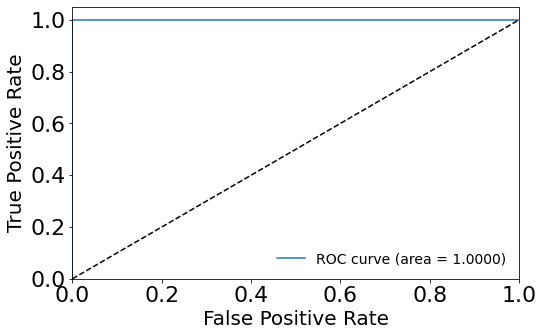

In [94]:
clf, y_pred= make_model(RandomForestClassifier(), x_train, y_train, x_test)
report(y_pred, y_test)
complete_recap['no_fs']['default_rf'] = (y_test, y_pred)

Since the results obtained in the evaluation phase are the same obtained in the validation phase, we can assure there was not any trace of overfitting

#### Random forest w/ hyper-parameter tuning

In [95]:
def make_hp_tuning(clf, param_list, X, y):

  # apply the random state 
  rs= {'random_state': 42}
  clf.set_params(**rs)
  # set cross validation parameters
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2 , random_state=42)
  scorer = make_scorer(recall_score, pos_label=0)

  # make a grid search cv in order to do hyper-parameter tuning
  grid_search = GridSearchCV(clf, param_grid=param_list, scoring= scorer, cv = cv )
  grid_search.fit(X, y)
  # reoirt the various cv
  report_cv(grid_search.cv_results_, n_top=3)
  # return the best model
  return grid_search.best_estimator_

Since we are interested in the simplest and best model, we perform a grid_search tuning on the number of trees and the depth of each tree, in this way we can get a simpler model. For the validation we used a RepeatedStratifiedKfold with 5 splits and 2 repetitions and the scoring was the recall of the poisonous. 

In [96]:
param_list = {'max_depth': [x for x in range(2,10)],
              'n_estimators': [x for x in range(2,20)]
              }

opt_rf= make_hp_tuning(RandomForestClassifier(), param_list, x_train, y_train )

Mean validation score: 1.00000 (std: 0.00000)
Parameters: {'max_depth': 9, 'n_estimators': 2}

Mean validation score: 1.00000 (std: 0.00000)
Parameters: {'max_depth': 9, 'n_estimators': 7}

Mean validation score: 1.00000 (std: 0.00000)
Parameters: {'max_depth': 9, 'n_estimators': 12}

Mean validation score: 1.00000 (std: 0.00000)
Parameters: {'max_depth': 9, 'n_estimators': 13}

Mean validation score: 1.00000 (std: 0.00000)
Parameters: {'max_depth': 9, 'n_estimators': 14}

Mean validation score: 1.00000 (std: 0.00000)
Parameters: {'max_depth': 9, 'n_estimators': 15}

Mean validation score: 1.00000 (std: 0.00000)
Parameters: {'max_depth': 9, 'n_estimators': 16}

Mean validation score: 1.00000 (std: 0.00000)
Parameters: {'max_depth': 9, 'n_estimators': 17}

Mean validation score: 1.00000 (std: 0.00000)
Parameters: {'max_depth': 9, 'n_estimators': 18}

Mean validation score: 1.00000 (std: 0.00000)
Parameters: {'max_depth': 9, 'n_estimators': 19}



results on test set:
Accuracy 0.9991796554552912
F1-score [0.99914821 0.99920886]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1175
           1       1.00      1.00      1.00      1263

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438

Confusion Matrix:
[[1173    2]
 [   0 1263]]



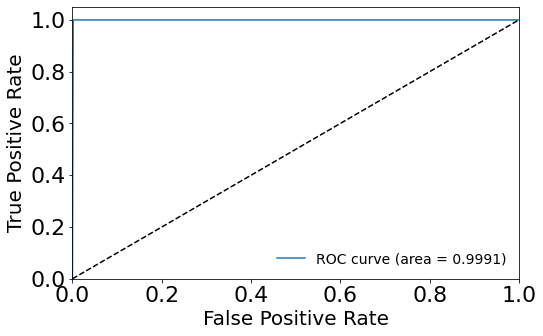

In [97]:
opt_rf.fit(x_train, y_train)
y_pred = opt_rf.predict(x_test)
report(y_pred, y_test)
complete_recap['no_fs']['rf'] = (y_test, y_pred)

It was decided to tune the parameters: "max_depth" and "n_estimators", which are respectively 9 and 2.
However the model found by the grid search is less computational expensive while giving as output the same scores as the default classifier. 
Also we notice absence of overfitting since the accuracy of train and test set is almost the same.

### Decision tree

#### Default Decision tree

As before we proceed with the comparison of the Decision tree classifier with default parameters and the Decision tree classifier but with a tree less deep in order to make the model simpler.

CV-scores: 1.00 recall with a standard deviation of 0.00
CV-scores: 1.00 accuracy with a standard deviation of 0.00

results on test set:
Accuracy 1.0
F1-score [1. 1.]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1175
           1       1.00      1.00      1.00      1263

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438

Confusion Matrix:
[[1175    0]
 [   0 1263]]



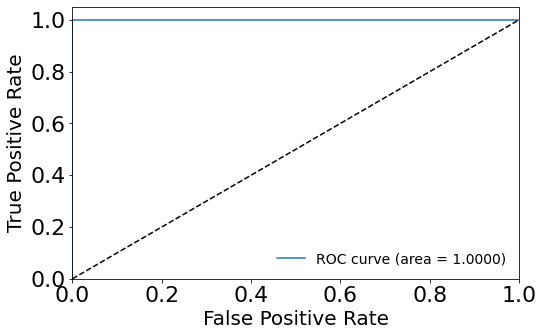

In [98]:
clf, y_pred= make_model(DecisionTreeClassifier(), x_train, y_train, x_test)
report(y_pred, y_test)
complete_recap['no_fs']['default_dt'] = (y_test, y_pred)

#### Decision tree w/ hyper-parameter tuning

The hyper-parameter tuning follows the same structure as before, but this time we focused on tuning the depth and the splitting criterion.

In [99]:
param_list = {'max_depth': [x for x in range(2,15)],
              'criterion': ['gini', 'entropy']
              }

opt_dt= make_hp_tuning(DecisionTreeClassifier(), param_list, x_train, y_train )

Mean validation score: 0.99964 (std: 0.00073)
Parameters: {'criterion': 'gini', 'max_depth': 8}

Mean validation score: 0.99964 (std: 0.00073)
Parameters: {'criterion': 'gini', 'max_depth': 9}

Mean validation score: 0.99964 (std: 0.00073)
Parameters: {'criterion': 'gini', 'max_depth': 10}

Mean validation score: 0.99964 (std: 0.00073)
Parameters: {'criterion': 'gini', 'max_depth': 11}

Mean validation score: 0.99964 (std: 0.00073)
Parameters: {'criterion': 'gini', 'max_depth': 12}

Mean validation score: 0.99964 (std: 0.00073)
Parameters: {'criterion': 'gini', 'max_depth': 13}

Mean validation score: 0.99964 (std: 0.00073)
Parameters: {'criterion': 'gini', 'max_depth': 14}

Mean validation score: 0.99964 (std: 0.00073)
Parameters: {'criterion': 'entropy', 'max_depth': 7}

Mean validation score: 0.99964 (std: 0.00073)
Parameters: {'criterion': 'entropy', 'max_depth': 8}

Mean validation score: 0.99964 (std: 0.00073)
Parameters: {'criterion': 'entropy', 'max_depth': 9}

Mean validation 

results on test set:
Accuracy 1.0
F1-score [1. 1.]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1175
           1       1.00      1.00      1.00      1263

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438

Confusion Matrix:
[[1175    0]
 [   0 1263]]



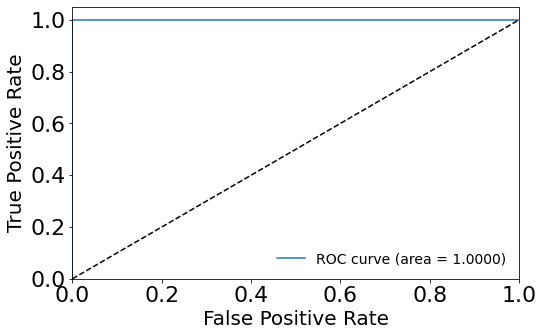

In [100]:
opt_dt.fit(x_train, y_train)
y_pred = opt_dt.predict(x_test)
report(y_pred, y_test)
complete_recap['no_fs']['dt'] = (y_test, y_pred)

The obtained results of the optimized version are the same of the default version, but this time the model is simpler.

## With feature selection

In order to make this part, we used the hyper-parameter tuned model and we apply the RFE in order to see how many features needs in order to get the better results. After that we evaluate the model with the reduced data. In order to decide how many features we want, we follow the elbow method using the plot below

### Decision tree

2 0.829 (0.015)
3 0.901 (0.008)
4 0.961 (0.015)
5 0.984 (0.008)
6 0.995 (0.005)
7 0.998 (0.003)
8 0.999 (0.003)
9 0.999 (0.001)
10 1.000 (0.001)
11 1.000 (0.001)


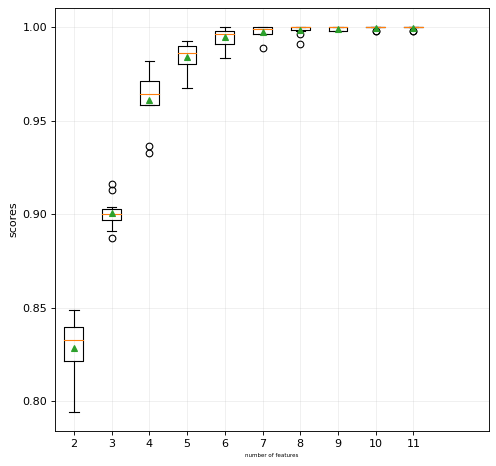

In [101]:
mushrooms_ohe = pd.read_csv('mushrooms_ohe.csv', index_col=0)
params = {'max_depth': 8}
x_train, x_test, y_train, y_test = test_split(mushrooms_ohe)
get_n_feature_rfe(mushrooms_ohe, DecisionTreeClassifier(), params = params)

More or less the best number of features needed for this model is 6

In [102]:
get_name_cols_rfe(mushrooms_ohe,6, x_train, y_train)

Column: bruises, Selected True, Rank: 1.000
Column: odor_n, Selected True, Rank: 1.000
Column: odor_p, Selected True, Rank: 1.000
Column: spore-print-color_h, Selected True, Rank: 1.000
Column: spore-print-color_r, Selected True, Rank: 1.000
Column: habitat_u, Selected True, Rank: 1.000


recall: 0.995 (0.005)
results on test set:
Accuracy 0.9979491386382281
F1-score [0.99785131 0.99803845]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1166
           1       1.00      1.00      1.00      1272

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438

Confusion Matrix:
[[1161    5]
 [   0 1272]]



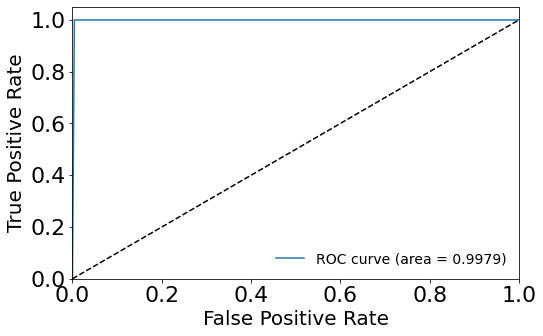

In [103]:
params = {'max_depth': 8}
y_test, y_pred= eval_rfe_model(mushrooms_ohe, DecisionTreeClassifier(), 6, params)
complete_recap['fs']['dt'] = (y_test, y_pred)

### Random forest

We followed the same procedure done for the Decision tree classifier above

2 0.829 (0.015)
3 0.901 (0.008)
4 0.961 (0.015)
5 0.984 (0.008)
6 0.995 (0.005)
7 0.998 (0.003)
8 0.999 (0.003)
9 0.999 (0.001)
10 1.000 (0.001)
11 0.999 (0.001)


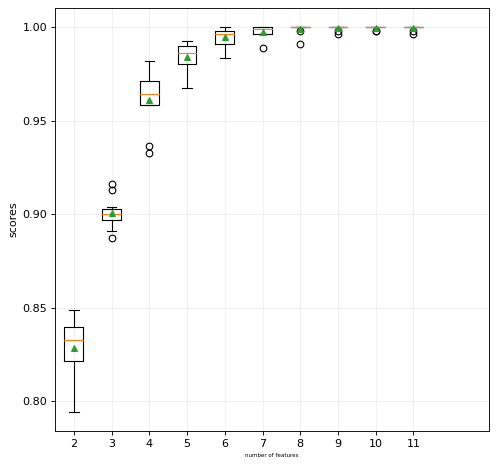

In [104]:
params = {'n_estimators': 2, 'max_depth': 9}
get_n_feature_rfe(mushrooms_ohe, RandomForestClassifier(), params = params)

recall: 0.995 (0.005)
results on test set:
Accuracy 0.9979491386382281
F1-score [0.99785131 0.99803845]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1166
           1       1.00      1.00      1.00      1272

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438

Confusion Matrix:
[[1161    5]
 [   0 1272]]



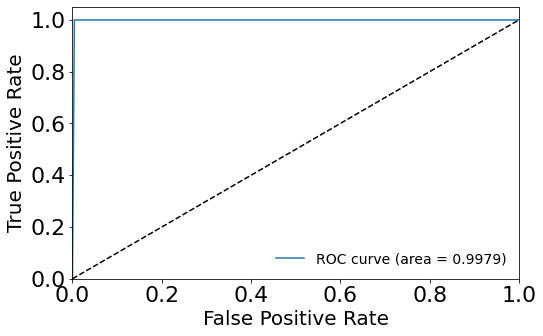

In [105]:
y_test, y_pred = eval_rfe_model(mushrooms_ohe, RandomForestClassifier(), 6, params)
complete_recap['fs']['rf'] = (y_test, y_pred)

The RFE method leads to more or less the same perfect results, but it tends to missclassify 5 mushrooms which are edible but the models classify as poisonous

# Reduced dataset: DT and RF

In [106]:
# read new datasets
mushrooms_ohe = pd.read_csv('mushrooms_ohe_less.csv', index_col=0)
label = mushrooms_ohe.pop('edible')

x_train, x_test, y_train, y_test = \
    train_test_split(
        mushrooms_ohe, label, stratify=label, test_size=0.3, random_state=42
    )

## Without feature selection

### Random forest

#### Default random forest

We trained a Random forest classifier model with the default parameters.

CV-scores: 1.00 recall with a standard deviation of 0.00
CV-scores: 1.00 accuracy with a standard deviation of 0.00

results on test set:
Accuracy 0.9975389663658737
F1-score [0.99744246 0.99762846]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1175
           1       1.00      1.00      1.00      1263

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438

Confusion Matrix:
[[1170    5]
 [   1 1262]]



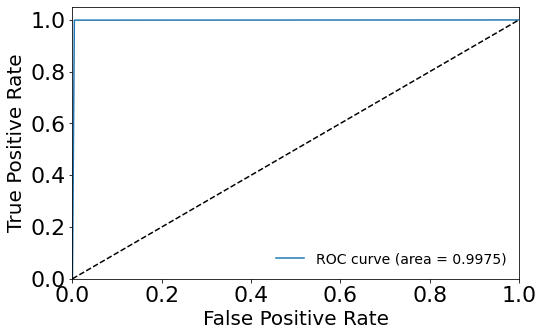

In [107]:
clf, y_pred= make_model(RandomForestClassifier(), x_train, y_train, x_test)
report(y_pred, y_test)
reduced_recap['no_fs']['default_rf'] = (y_test, y_pred)

#### Random forest w/ hyper-parameter tuning

In order to do the hyper-parameter tuning, we followed the same procedure we did for the original dataset

In [108]:
param_list = {'max_depth': [x for x in range(2,10)],
              'n_estimators': [x for x in range(2,20)]
              }

opt_rf= make_hp_tuning(RandomForestClassifier(), param_list, x_train, y_train )

Mean validation score: 0.98048 (std: 0.00522)
Parameters: {'max_depth': 9, 'n_estimators': 12}

Mean validation score: 0.97902 (std: 0.00518)
Parameters: {'max_depth': 9, 'n_estimators': 17}

Mean validation score: 0.97902 (std: 0.00543)
Parameters: {'max_depth': 9, 'n_estimators': 18}



results on test set:
Accuracy 0.9942575881870386
F1-score [0.9940273  0.99447077]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1175
           1       0.99      1.00      0.99      1263

    accuracy                           0.99      2438
   macro avg       0.99      0.99      0.99      2438
weighted avg       0.99      0.99      0.99      2438

Confusion Matrix:
[[1165   10]
 [   4 1259]]



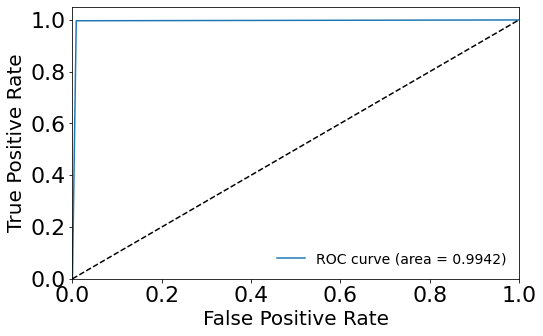

In [109]:
opt_rf.fit(x_train, y_train)
y_pred = opt_rf.predict(x_test)
report(y_pred, y_test)
reduced_recap['no_fs']['rf'] = (y_test, y_pred)

It seems that the non visual attributes that we discarded were useful to make a perfect classification, infact the recall of the poisonous mushrooms is decreased and in the test set 4 poisonous mushrooms are classified as edible and this is dangerous

### Decision tree

#### Default Decision tree

CV-scores: 1.00 recall with a standard deviation of 0.00
CV-scores: 1.00 accuracy with a standard deviation of 0.00

results on test set:
Accuracy 0.9967186218211649
F1-score [0.99659864 0.99683043]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1175
           1       1.00      1.00      1.00      1263

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438

Confusion Matrix:
[[1172    3]
 [   5 1258]]



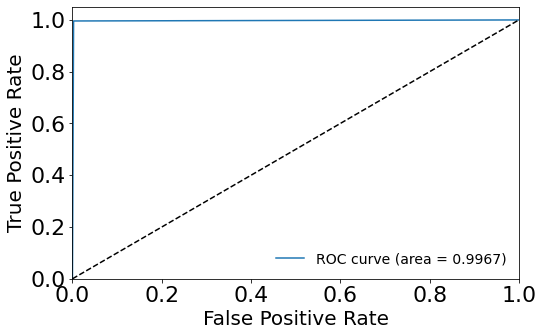

In [110]:
clf, y_pred= make_model(DecisionTreeClassifier(), x_train, y_train, x_test)
report(y_pred, y_test)
reduced_recap['no_fs']['default_dt'] = (y_test, y_pred)

#### Decision tree w/ hyper-parameter tuning

In [111]:
param_list = {'max_depth': [x for x in range(2, 15)],
              'criterion': ['gini', 'entropy']}

opt_dt= make_hp_tuning(DecisionTreeClassifier(), param_list, x_train, y_train )

Mean validation score: 0.99672 (std: 0.00242)
Parameters: {'criterion': 'entropy', 'max_depth': 12}

Mean validation score: 0.99635 (std: 0.00565)
Parameters: {'criterion': 'entropy', 'max_depth': 10}

Mean validation score: 0.99617 (std: 0.00172)
Parameters: {'criterion': 'gini', 'max_depth': 13}

Mean validation score: 0.99617 (std: 0.00172)
Parameters: {'criterion': 'gini', 'max_depth': 14}



results on test set:
Accuracy 0.9950779327317474
F1-score [0.99489362 0.99524941]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1175
           1       1.00      1.00      1.00      1263

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438

Confusion Matrix:
[[1169    6]
 [   6 1257]]



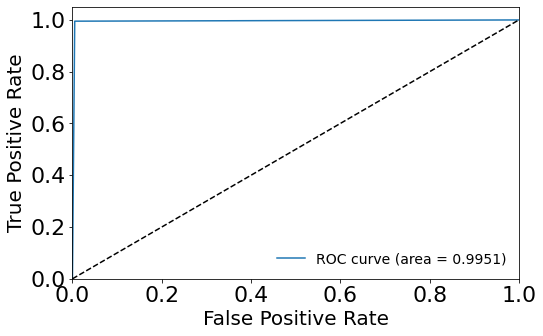

In [112]:
opt_dt.fit(x_train, y_train)
y_pred = opt_dt.predict(x_test)
report(y_pred, y_test)
reduced_recap['no_fs']['dt'] = (y_test, y_pred)

As for the random forest, even the decision tree with the reduced dataset behave worse than the decision tree with the complete dataset, infact we have 6 false edible and this is dangerous. Beside this hyper-parameter tuned decision tree has more or less the same performance of the default decision tree above.

## With feature selection

For this part we followed the same procedure as before, so deciding the number of feature with the elbow method using a RFE and then we use the hyper-parameter tuned models obtained before

### Decision tree

2 0.912 (0.008)
3 0.888 (0.013)
4 0.894 (0.028)
5 0.915 (0.016)
6 0.931 (0.020)
7 0.942 (0.011)
8 0.949 (0.007)
9 0.955 (0.007)
10 0.965 (0.007)
11 0.986 (0.005)
12 0.988 (0.004)
13 0.992 (0.004)
14 0.992 (0.004)
15 0.991 (0.005)
16 0.993 (0.004)
17 0.994 (0.005)
18 0.995 (0.004)
19 0.996 (0.004)


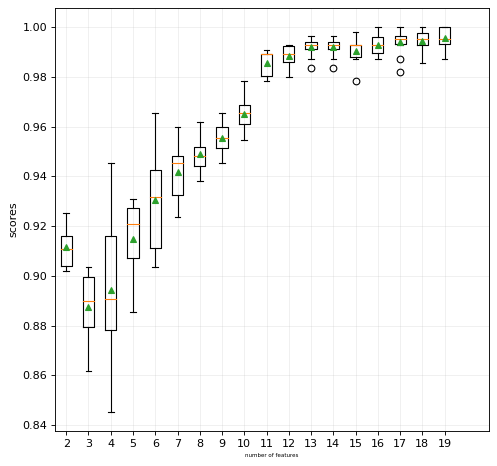

In [113]:
mushrooms_ohe = pd.read_csv('mushrooms_ohe_less.csv', index_col=0)
params = {'max_depth': 12, 'criterion': 'entropy'}
x_train, x_test, y_train, y_test = test_split(mushrooms_ohe)
get_n_feature_rfe(mushrooms_ohe, DecisionTreeClassifier(), max_features= 20 , params = params)

In [114]:
get_name_cols_rfe(mushrooms_ohe, 13, x_train, y_train)

Column: bruises, Selected True, Rank: 1.000
Column: gill-spacing, Selected True, Rank: 1.000
Column: gill-size, Selected True, Rank: 1.000
Column: stalk-shape, Selected True, Rank: 1.000
Column: cap-shape_x, Selected True, Rank: 1.000
Column: cap-surface_f, Selected True, Rank: 1.000
Column: cap-surface_s, Selected True, Rank: 1.000
Column: cap-color_b, Selected True, Rank: 1.000
Column: gill-color_r, Selected True, Rank: 1.000
Column: stalk-surface-above-ring_k, Selected True, Rank: 1.000
Column: stalk-surface-below-ring_f, Selected True, Rank: 1.000
Column: stalk-color-below-ring_n, Selected True, Rank: 1.000
Column: ring-type_e, Selected True, Rank: 1.000


recall: 0.992 (0.004)
results on test set:
Accuracy 0.9958982772764561
F1-score [0.99571184 0.99606918]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1166
           1       1.00      1.00      1.00      1272

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438

Confusion Matrix:
[[1161    5]
 [   5 1267]]



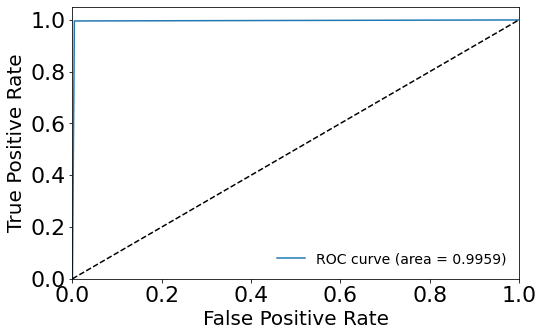

In [115]:
params = {'max_depth': 12}
y_test, y_pred = eval_rfe_model(mushrooms_ohe, DecisionTreeClassifier(), 13, params)
reduced_recap['fs']['dt'] = (y_test, y_pred)

### Random forest

2 0.912 (0.008)
3 0.883 (0.011)
4 0.903 (0.034)
5 0.916 (0.020)
6 0.933 (0.018)
7 0.945 (0.009)
8 0.948 (0.006)
9 0.956 (0.007)
10 0.965 (0.007)
11 0.984 (0.006)
12 0.989 (0.005)
13 0.992 (0.004)
14 0.991 (0.004)
15 0.987 (0.007)
16 0.990 (0.006)
17 0.991 (0.005)
18 0.994 (0.005)
19 0.992 (0.006)


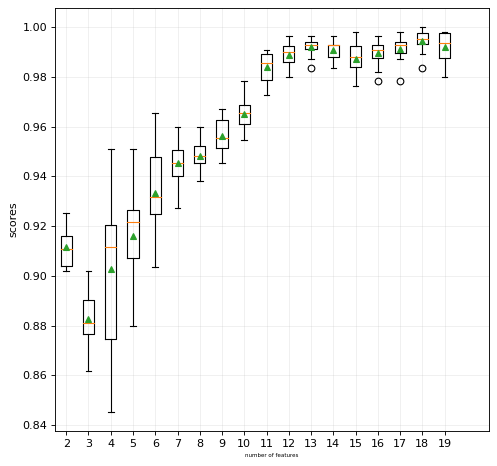

In [116]:
params = {'n_estimators': 12, 'max_depth': 9}
get_n_feature_rfe(mushrooms_ohe, RandomForestClassifier(), max_features= 20, params = params)

recall: 0.992 (0.004)
results on test set:
Accuracy 0.9958982772764561
F1-score [0.99571184 0.99606918]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1166
           1       1.00      1.00      1.00      1272

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438

Confusion Matrix:
[[1161    5]
 [   5 1267]]



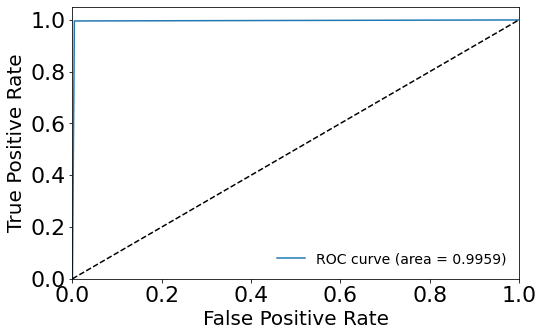

In [117]:
y_test, y_pred = eval_rfe_model(mushrooms_ohe, RandomForestClassifier(), 13, params)
reduced_recap['fs']['rf'] = (y_test, y_pred)

It seems that the RFE method does not lead to any improvement in performance for the Decision tree and even for the random forest

# Original dataset: CNB

In order to apply the CategoricalNB classifier we proceeded in same way of the other models:
* We performed a grid search over the parameters alpha and fit-prior and we found the best model with 6 iterations.
* Then we performed another version of the algorithm applying a feature selection with VarianceThreshold and Chi-square.

We repeated this process for both the complete version and the reduced version of the dataset.
Also, for all the version of the CategoricalNB It was decided to use the same split for traning (0.8) and test set (0.2).
 

## Without feature selection

### Categorical Naive Bayes

Performing a GridsearchCV in order to find the best parameters to apply to our model. In this phase was also applied a cv (cross-validation) with a RepeatedStratifiedKfold of 10 and 3 repeatitions.

In [118]:
df = pd.read_csv('mushrooms_ohe.csv', index_col=0)

In [119]:
label = df.pop('edible')
X_train, X_test, y_train, y_test = \
    train_test_split(
        df, label, stratify=label, test_size=0.2, random_state=42
    )

In [120]:
params = {
          'alpha': np.arange(0.1,1.1,0.1),
          'fit_prior': [True,False]
         }
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [121]:
cnb = CategoricalNB()
cnbgrid = GridSearchCV(CategoricalNB(), params,
                        scoring='accuracy',n_jobs=-1,
                        cv=cv, verbose=3, error_score='raise').fit(X_train, y_train)
print('\nThe best model selected is:\n{}'.format(cnbgrid.best_estimator_))
report_cv(cnbgrid.cv_results_)

Fitting 30 folds for each of 20 candidates, totalling 600 fits

The best model selected is:
CategoricalNB(alpha=0.1, fit_prior=False)
Mean validation score: 0.95527 (std: 0.01015)
Parameters: {'alpha': 0.1, 'fit_prior': False}

Mean validation score: 0.95471 (std: 0.00992)
Parameters: {'alpha': 0.1, 'fit_prior': True}

Mean validation score: 0.94922 (std: 0.00947)
Parameters: {'alpha': 0.2, 'fit_prior': False}

Mean validation score: 0.94861 (std: 0.00915)
Parameters: {'alpha': 0.2, 'fit_prior': True}

Mean validation score: 0.94614 (std: 0.00942)
Parameters: {'alpha': 0.30000000000000004, 'fit_prior': False}

Mean validation score: 0.94558 (std: 0.00935)
Parameters: {'alpha': 0.30000000000000004, 'fit_prior': True}

Mean validation score: 0.94368 (std: 0.00862)
Parameters: {'alpha': 0.4, 'fit_prior': False}



In [122]:
print(cnbgrid.best_params_)

{'alpha': 0.1, 'fit_prior': False}


In [123]:
cnb=CategoricalNB(**cnbgrid.best_params_).fit(X_train, y_train)

In [124]:
y_pred_tr = cnb.predict(X_train)

print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average=None))

print(classification_report(y_train, y_pred_tr))
pd.DataFrame(confusion_matrix(y_train, y_pred_tr),
             index = ['class 0 actual', 'class 1 actual'],
             columns = ['class 0 pred', 'class 1 pred'])

Train Accuracy 0.9581474072934297
Train F1-score [0.95501158 0.96087457]
              precision    recall  f1-score   support

           0       0.99      0.92      0.96      3133
           1       0.93      0.99      0.96      3366

    accuracy                           0.96      6499
   macro avg       0.96      0.96      0.96      6499
weighted avg       0.96      0.96      0.96      6499



,class 0 pred,class 1 pred
class 0 actual,2887,246
class 1 actual,26,3340


In [125]:
y_pred = cnb.predict(X_test)
print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s' % f1_score(y_test, y_pred, average=None))

print(classification_report(y_test, y_pred))
pd.DataFrame(confusion_matrix(y_test, y_pred),
             index = ['class 0 actual', 'class 1 actual'],
             columns = ['class 0 pred', 'class 1 pred'])

Test Accuracy 0.9649230769230769
Test F1-score [0.96242584 0.96710906]
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       783
           1       0.94      1.00      0.97       842

    accuracy                           0.96      1625
   macro avg       0.97      0.96      0.96      1625
weighted avg       0.97      0.96      0.96      1625



,class 0 pred,class 1 pred
class 0 actual,730,53
class 1 actual,4,838


From our results we observe no overfitting since the accuracy on the training set is 0.958 while on the test set is 0.964. Naive Bayes family algorithms supports very few parameters wich are enough to enhance our predictions reducing the number of poisonus mushrooms predicted as edibles, this is denoted by a recall on class 0 of 0.93. In order to avoid completely the possibility of predicting a poisonus mushroom as edible, it was decided to manually tune the threshold of our model, so that we have no poisonus mushrooms predicted as edibles, while also trying to minimize the errors in classifying edibles mushrooms as poisonous.

In [126]:
yprobcnbnopre = cnb.predict_proba(X_test)[:,1]
print("AUC:", round(roc_auc_score(y_test, yprobcnbnopre),2))

AUC: 1.0


In [127]:
th=0.999997
print(classification_report(y_test, yprobcnbnopre>th))
pd.DataFrame(confusion_matrix(y_test, yprobcnbnopre>th),
             index = ['class 0 actual', 'class 1 actual'],
             columns = ['class 0 pred', 'class 1 pred'])

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       783
           1       1.00      0.90      0.95       842

    accuracy                           0.95      1625
   macro avg       0.95      0.95      0.95      1625
weighted avg       0.95      0.95      0.95      1625



,class 0 pred,class 1 pred
class 0 actual,783,0
class 1 actual,86,756


## With feature selection

### Categorical Naive Bayes

Naive Bayes family algorithm assume statistical indipendence between features. In order to use only statistical indipendent feature for our model it was decided to use the VarianceThreshold first, wich is a filter method, and then we proceed to remove one attribute from each pair of features with the highest correlation on the Chramer's V matrix using chi-square: in particular, between the 2, it was decided to remove the column with less correlation with the target variable.

In [128]:
df = pd.read_csv('mushrooms_ohe.csv')
df1 = df.copy()
df = df.drop(['Unnamed: 0', 'edible'], 1)

For the VarianceThreshold it was decided to choose a threshold of 0.8: this means that the features with more of 80% of the records with the same value will be discarded. The same threshold will be applied for the reduced version of the dataset.

In [129]:
feature_selection_variance_model = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_selected_features_variance = feature_selection_variance_model.fit_transform(df)

print("Original data set shape is ", df.shape)
print("Reduced data set shape is ", X_selected_features_variance.shape)

mask = feature_selection_variance_model.get_support() #list of booleans
print("Selected features = ", df.columns[mask])

Original data set shape is  (8124, 106)
Reduced data set shape is  (8124, 31)
Selected features =  Index(['bruises', 'gill-size', 'stalk-shape', 'cap-shape_f', 'cap-shape_x',
       'cap-surface_f', 'cap-surface_s', 'cap-surface_y', 'cap-color_g',
       'cap-color_n', 'odor_f', 'odor_n', 'gill-color_b',
       'stalk-surface-above-ring_k', 'stalk-surface-above-ring_s',
       'stalk-surface-below-ring_k', 'stalk-surface-below-ring_s',
       'stalk-color-above-ring_p', 'stalk-color-above-ring_w',
       'stalk-color-below-ring_p', 'stalk-color-below-ring_w', 'ring-type_e',
       'ring-type_p', 'spore-print-color_h', 'spore-print-color_k',
       'spore-print-color_n', 'spore-print-color_w', 'population_v',
       'population_y', 'habitat_d', 'habitat_g'],
      dtype='object')


In [130]:
columnstomaintain=list(df.columns[mask])
for col in df.columns:
    if col not in columnstomaintain:
        df=df.drop(col,1)
df['edible']=df1['edible']

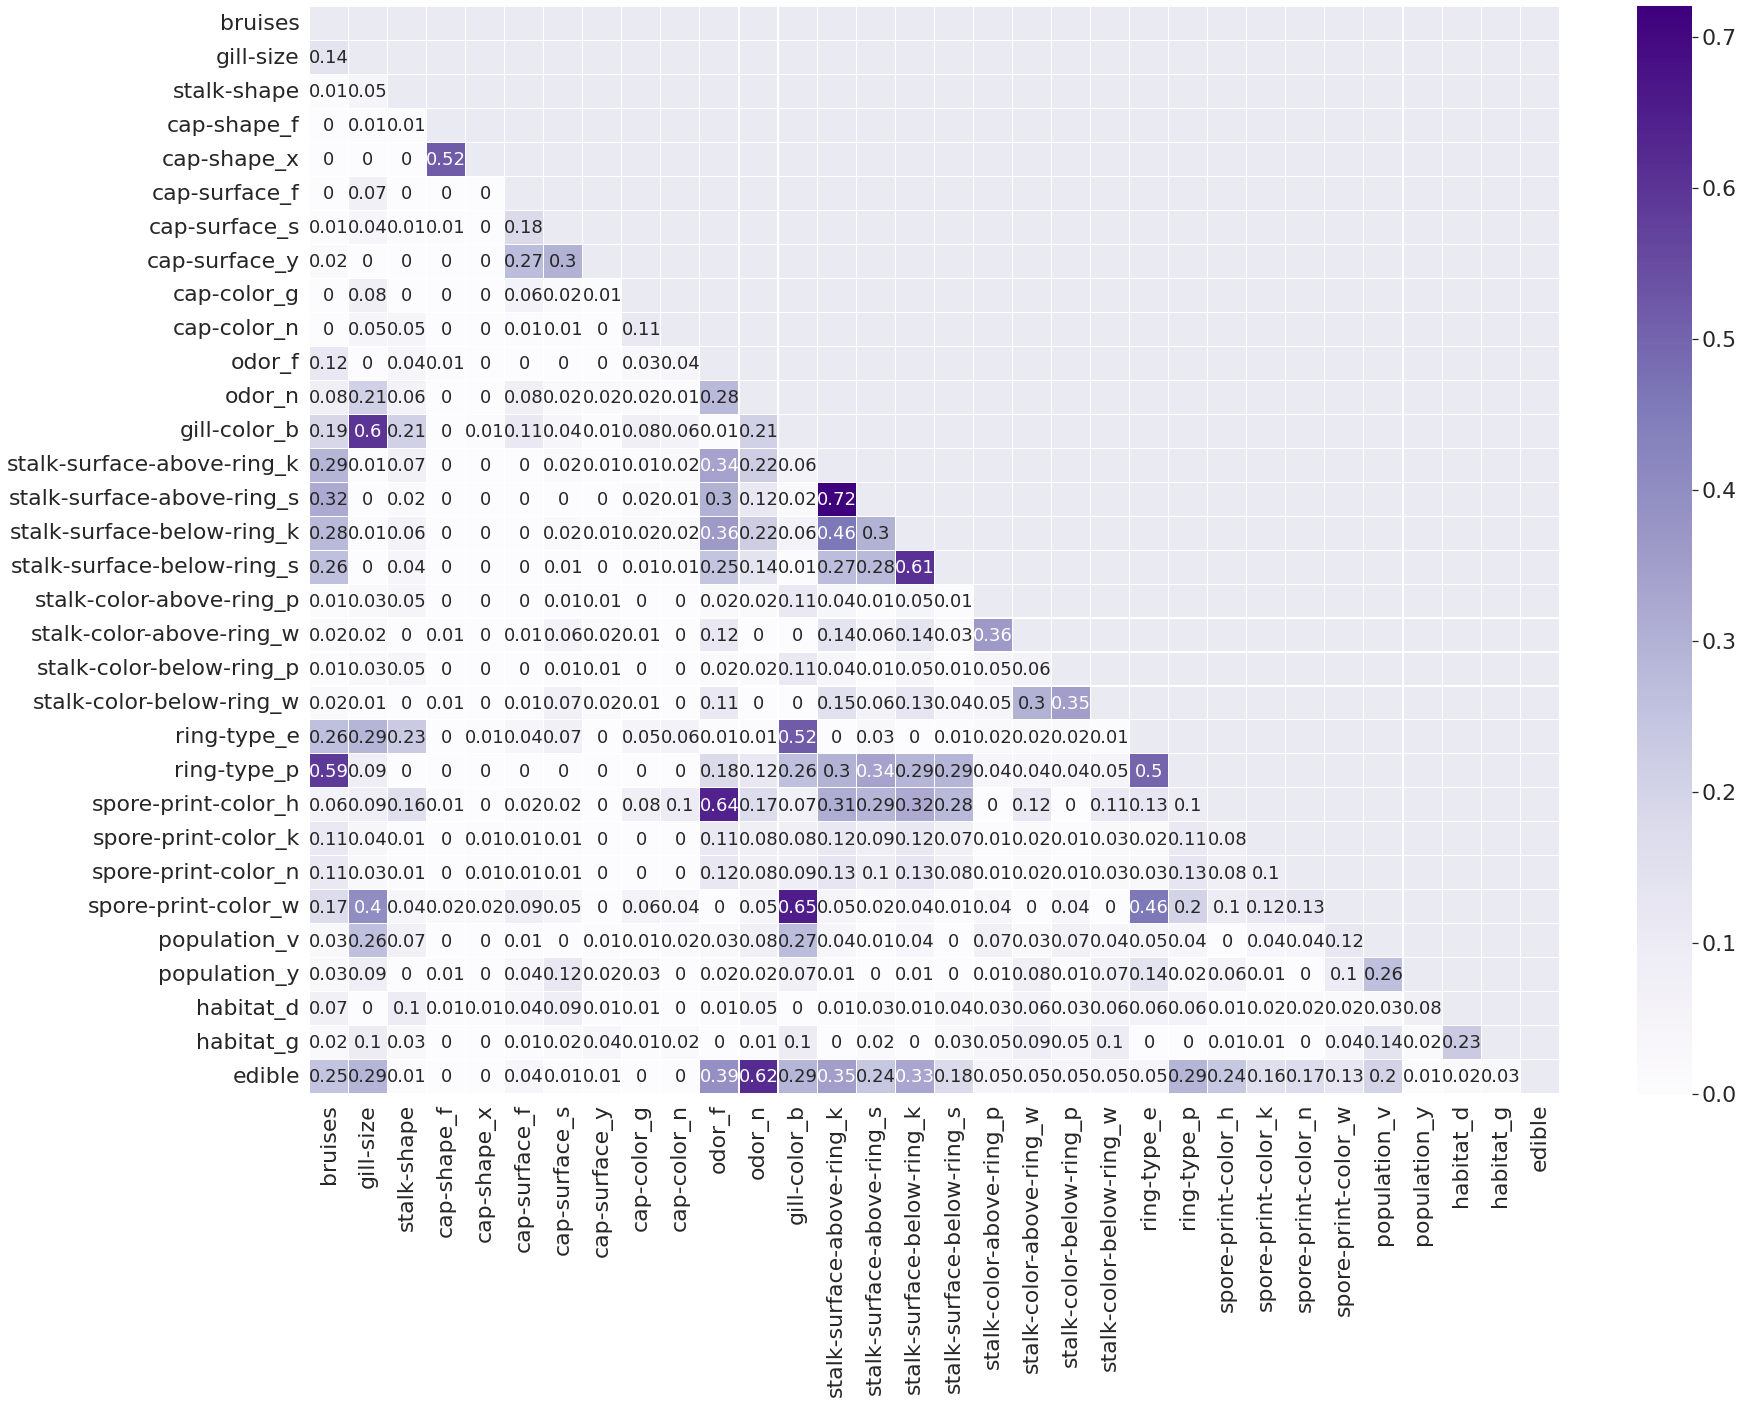

In [131]:
sns.set()
rows = []
sns.set(font_scale=2)
for var1 in df:
    col = []
    for var2 in df:
        cramers =cramers_V(df[var1], df[var2])  
        col.append(round(cramers,2))
    rows.append(col)
  
cramers_results = np.array(rows)
corr = pd.DataFrame(cramers_results, columns=df.columns, index=df.columns)
# Generate a mask for the upper triangle.
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(28, 20))
sns.heatmap(corr,linewidths=.1, mask=mask, cmap="Purples", annot=True, annot_kws={"size": 18})
plt.show()

In order to choose if a pair of attributes were statistically independent or not, it was arbitrarly decided to choose a threshold of 0.5: this means that we will consider only the pairs of features with a correlation of more than 0.5 on the Chramer's V matrix.

In [132]:
correlated_features=['spore-print-color_h','spore-print-color_w','bruises','stalk-surface-below-ring_s','stalk-surface-above-ring_s','gill-color_b','cap-shape_x']
print(len(correlated_features))
df=df.drop(correlated_features,1)
print(df.shape)

7
(8124, 25)


There are 7 feature wich are statistically dependent from others, so we proceed to remove them. After the feature selection phase our model will run on 25 features.

In [133]:
label = df.pop('edible')
X_train, X_test, y_train, y_test = \
    train_test_split(
        df, label, stratify=label, test_size=0.2, random_state=42)

In [134]:
params = {
          'alpha': np.arange(0.1,1.1,0.1),
          'fit_prior': [True,False]
         }
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [135]:
cnb = CategoricalNB()
cnbgrid = GridSearchCV(cnb, param_grid = params, 
                                   scoring='accuracy',n_jobs=-1,  
                                   cv=cv, verbose=3).fit(X_train, y_train)
print('\nThe best model selected is:\n{}'.format(cnbgrid.best_estimator_))
report_cv(cnbgrid.cv_results_)

Fitting 30 folds for each of 20 candidates, totalling 600 fits

The best model selected is:
CategoricalNB(alpha=0.1)
Mean validation score: 0.92619 (std: 0.00959)
Parameters: {'alpha': 0.1, 'fit_prior': True}

Mean validation score: 0.92619 (std: 0.00959)
Parameters: {'alpha': 0.1, 'fit_prior': False}

Mean validation score: 0.92619 (std: 0.00959)
Parameters: {'alpha': 0.2, 'fit_prior': True}

Mean validation score: 0.92619 (std: 0.00959)
Parameters: {'alpha': 0.2, 'fit_prior': False}

Mean validation score: 0.92619 (std: 0.00959)
Parameters: {'alpha': 0.30000000000000004, 'fit_prior': True}

Mean validation score: 0.92619 (std: 0.00959)
Parameters: {'alpha': 0.30000000000000004, 'fit_prior': False}

Mean validation score: 0.92619 (std: 0.00959)
Parameters: {'alpha': 0.4, 'fit_prior': True}

Mean validation score: 0.92619 (std: 0.00959)
Parameters: {'alpha': 0.4, 'fit_prior': False}

Mean validation score: 0.92619 (std: 0.00959)
Parameters: {'alpha': 0.5, 'fit_prior': True}

Mean valid

In [136]:
cnb=CategoricalNB(**cnbgrid.best_params_).fit(X_train, y_train)

In [137]:
y_pred_tr = cnb.predict(X_train)

print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average=None))

print(classification_report(y_train, y_pred_tr))
pd.DataFrame(confusion_matrix(y_train, y_pred_tr),
             index = ['class 0 actual', 'class 1 actual'],
             columns = ['class 0 pred', 'class 1 pred'])

Train Accuracy 0.9261424834589936
Train F1-score [0.91820041 0.93267882]
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      3133
           1       0.88      0.99      0.93      3366

    accuracy                           0.93      6499
   macro avg       0.93      0.92      0.93      6499
weighted avg       0.93      0.93      0.93      6499



,class 0 pred,class 1 pred
class 0 actual,2694,439
class 1 actual,41,3325


In [138]:
y_pred = cnb.predict(X_test)
print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s' % f1_score(y_test, y_pred, average=None))

print(classification_report(y_test, y_pred))
pd.DataFrame(confusion_matrix(y_test, y_pred),
             index = ['class 0 actual', 'class 1 actual'],
             columns = ['class 0 pred', 'class 1 pred'])

Test Accuracy 0.936
Test F1-score [0.9295393  0.94137542]
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       783
           1       0.90      0.99      0.94       842

    accuracy                           0.94      1625
   macro avg       0.94      0.93      0.94      1625
weighted avg       0.94      0.94      0.94      1625



,class 0 pred,class 1 pred
class 0 actual,686,97
class 1 actual,7,835


From the preprocessed version of the model we observe no overfitting, since the accuracy on training and test set are almost the same and a reduction in the computational complexity: however we do have a decrease in the recall for class 0 wich is 0.88 with respect of the version of the model without feature selection with 0.93. Also in this case, in order to avoid these kind of errors, it was decided to manually tune the threshold so that we avoid to classify a poisonus mushroom as an edible one.

In [139]:
yprobcnbpre = cnb.predict_proba(X_test)[:,1]
print("AUC:", round(roc_auc_score(y_test, yprobcnbpre),2))

AUC: 0.99


In [140]:
th=0.9992
print(classification_report(y_test, yprobcnbpre>th))
pd.DataFrame(confusion_matrix(y_test, yprobcnbpre>th),
             index = ['class 0 actual', 'class 1 actual'],
             columns = ['class 0 pred', 'class 1 pred'])

              precision    recall  f1-score   support

           0       0.70      1.00      0.82       783
           1       1.00      0.60      0.75       842

    accuracy                           0.79      1625
   macro avg       0.85      0.80      0.79      1625
weighted avg       0.86      0.79      0.79      1625



,class 0 pred,class 1 pred
class 0 actual,783,0
class 1 actual,335,507


# Reduced Dataset: CNB

In order to apply our classification model to the reduced version of the dataset, it was decided to proceed in the same way of the complete version: we first applied an hyper-parameter tuned version and then the same type of preprocessing (variance threshold and chi-square) was applied.

## Without feature selection

### Categorical Naive Bayes

Performing a GridsearchCV in order to find the best parameters to apply to our model. In this phase was also applied a cv (cross-validation) with a RepeatedStratifiedKfold of 10 and 3 repetitions.

In [141]:
df = pd.read_csv('mushrooms_ohe_less.csv',index_col=0)

In [142]:
label = df.pop('edible')
X_train, X_test, y_train, y_test2 = \
    train_test_split(
        df, label, stratify=label, test_size=0.2, random_state=42)

In [143]:
params = {
          'alpha': np.arange(0.1,1.1,0.1),
          'fit_prior': [True,False]
         }
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [144]:
cnb = CategoricalNB()
cnbgrid = GridSearchCV(cnb, param_grid = params, 
                                   scoring='accuracy',n_jobs=-1,  
                                   cv=cv, verbose=3).fit(X_train, y_train)
print('\nThe best model selected is:\n{}'.format(cnbgrid.best_estimator_))
report_cv(cnbgrid.cv_results_)

Fitting 30 folds for each of 20 candidates, totalling 600 fits

The best model selected is:
CategoricalNB(alpha=0.1)
Mean validation score: 0.89039 (std: 0.01099)
Parameters: {'alpha': 0.1, 'fit_prior': True}

Mean validation score: 0.89039 (std: 0.01099)
Parameters: {'alpha': 0.2, 'fit_prior': True}

Mean validation score: 0.89039 (std: 0.01099)
Parameters: {'alpha': 0.30000000000000004, 'fit_prior': True}

Mean validation score: 0.89039 (std: 0.01099)
Parameters: {'alpha': 0.4, 'fit_prior': True}

Mean validation score: 0.89039 (std: 0.01099)
Parameters: {'alpha': 0.5, 'fit_prior': True}

Mean validation score: 0.89039 (std: 0.01099)
Parameters: {'alpha': 0.6, 'fit_prior': True}

Mean validation score: 0.89039 (std: 0.01099)
Parameters: {'alpha': 0.7000000000000001, 'fit_prior': True}

Mean validation score: 0.89039 (std: 0.01099)
Parameters: {'alpha': 0.8, 'fit_prior': True}

Mean validation score: 0.89039 (std: 0.01099)
Parameters: {'alpha': 0.9, 'fit_prior': True}

Mean validation

In [145]:
cnb=CategoricalNB(**cnbgrid.best_params_).fit(X_train, y_train)

In [146]:
y_pred_tr = cnb.predict(X_train)

print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average=None))

print(classification_report(y_train, y_pred_tr))
pd.DataFrame(confusion_matrix(y_train, y_pred_tr),
             index = ['class 0 actual', 'class 1 actual'],
             columns = ['class 0 pred', 'class 1 pred'])

Train Accuracy 0.8910601631020157
Train F1-score [0.8743344 0.9038566]
              precision    recall  f1-score   support

           0       0.98      0.79      0.87      3133
           1       0.83      0.99      0.90      3366

    accuracy                           0.89      6499
   macro avg       0.91      0.89      0.89      6499
weighted avg       0.91      0.89      0.89      6499



,class 0 pred,class 1 pred
class 0 actual,2463,670
class 1 actual,38,3328


In [147]:
y_pred = cnb.predict(X_test)
print('Test Accuracy %s' % accuracy_score(y_test2, y_pred))
print('Test F1-score %s' % f1_score(y_test2, y_pred, average=None))

print(classification_report(y_test2, y_pred))
pd.DataFrame(confusion_matrix(y_test2, y_pred),
             index = ['class 0 actual', 'class 1 actual'],
             columns = ['class 0 pred', 'class 1 pred'])

Test Accuracy 0.9070769230769231
Test F1-score [0.89403509 0.91726027]
              precision    recall  f1-score   support

           0       0.99      0.81      0.89       783
           1       0.85      0.99      0.92       842

    accuracy                           0.91      1625
   macro avg       0.92      0.90      0.91      1625
weighted avg       0.92      0.91      0.91      1625



,class 0 pred,class 1 pred
class 0 actual,637,146
class 1 actual,5,837


We can observe that in the hyper-parameter tuned version of the model we have an accuracy of 0.891 on the training set and of 0.907 on the test set, so also in this case we notice no overfitting.

In [148]:
yprobcnbnoprered = cnb.predict_proba(X_test)[:,1]
print("AUC:", round(roc_auc_score(y_test2, yprobcnbnoprered), 2))

AUC: 0.95


In order to decrease to 0 the number of poisonus mushrooms predicted as edibles it was decided to manually tune the threshold, which resulted, however, in a significant increase in the number of edible mushrooms predicted as poisonus, this means that: in order to not classify a poisonus shroom as edible, we are accepting the fact that most of the time our model will classify an edible shroom as poisonus.

In [149]:
th=0.9999998
print(classification_report(y_test2, yprobcnbnoprered>th))
pd.DataFrame(confusion_matrix(y_test2, yprobcnbnoprered>th),
             index = ['class 0 actual', 'class 1 actual'],
             columns = ['class 0 pred', 'class 1 pred'])

              precision    recall  f1-score   support

           0       0.56      1.00      0.72       783
           1       1.00      0.26      0.42       842

    accuracy                           0.62      1625
   macro avg       0.78      0.63      0.57      1625
weighted avg       0.79      0.62      0.56      1625



,class 0 pred,class 1 pred
class 0 actual,783,0
class 1 actual,619,223


## With feature selection

### Categorical Naive Bayes

In order to compare the preprocessed version of the reduced dataset with the hyper-parameter tuned version, and also with the preprocessed version of the complete dataset, it was decided to maintain the same type of preprocessing,this means that we applied the VarianceThreshold, followed by removing one from each pairs of statistically dependent columns and still choosing the one which is less dependent from the target variable.

In [150]:
df = pd.read_csv('mushrooms_ohe_less.csv')
df1=df.copy()
df=df.drop(['Unnamed: 0','edible'],1)

For the VarianceThreshold it was decided to choose a threshold of 0.8: this means that the features with more of 80% of the records with the same value will be discarded.

In [151]:
feature_selection_variance_model = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_selected_features_variance = feature_selection_variance_model.fit_transform(df)

print("Original data set shape is ", df.shape)
print("Reduced data set shape is ", X_selected_features_variance.shape)

mask = feature_selection_variance_model.get_support() #list of booleans
print("Selected features = ", df.columns[mask])

Original data set shape is  (8124, 75)
Reduced data set shape is  (8124, 21)
Selected features =  Index(['bruises', 'gill-size', 'stalk-shape', 'cap-shape_f', 'cap-shape_x',
       'cap-surface_f', 'cap-surface_s', 'cap-surface_y', 'cap-color_g',
       'cap-color_n', 'gill-color_b', 'stalk-surface-above-ring_k',
       'stalk-surface-above-ring_s', 'stalk-surface-below-ring_k',
       'stalk-surface-below-ring_s', 'stalk-color-above-ring_p',
       'stalk-color-above-ring_w', 'stalk-color-below-ring_p',
       'stalk-color-below-ring_w', 'ring-type_e', 'ring-type_p'],
      dtype='object')


In [152]:
columnstomaintain=list(df.columns[mask])
for col in df.columns:
    if col not in columnstomaintain:
        df=df.drop(col,1)
df['edible']=df1['edible']
print(df.shape)

(8124, 22)


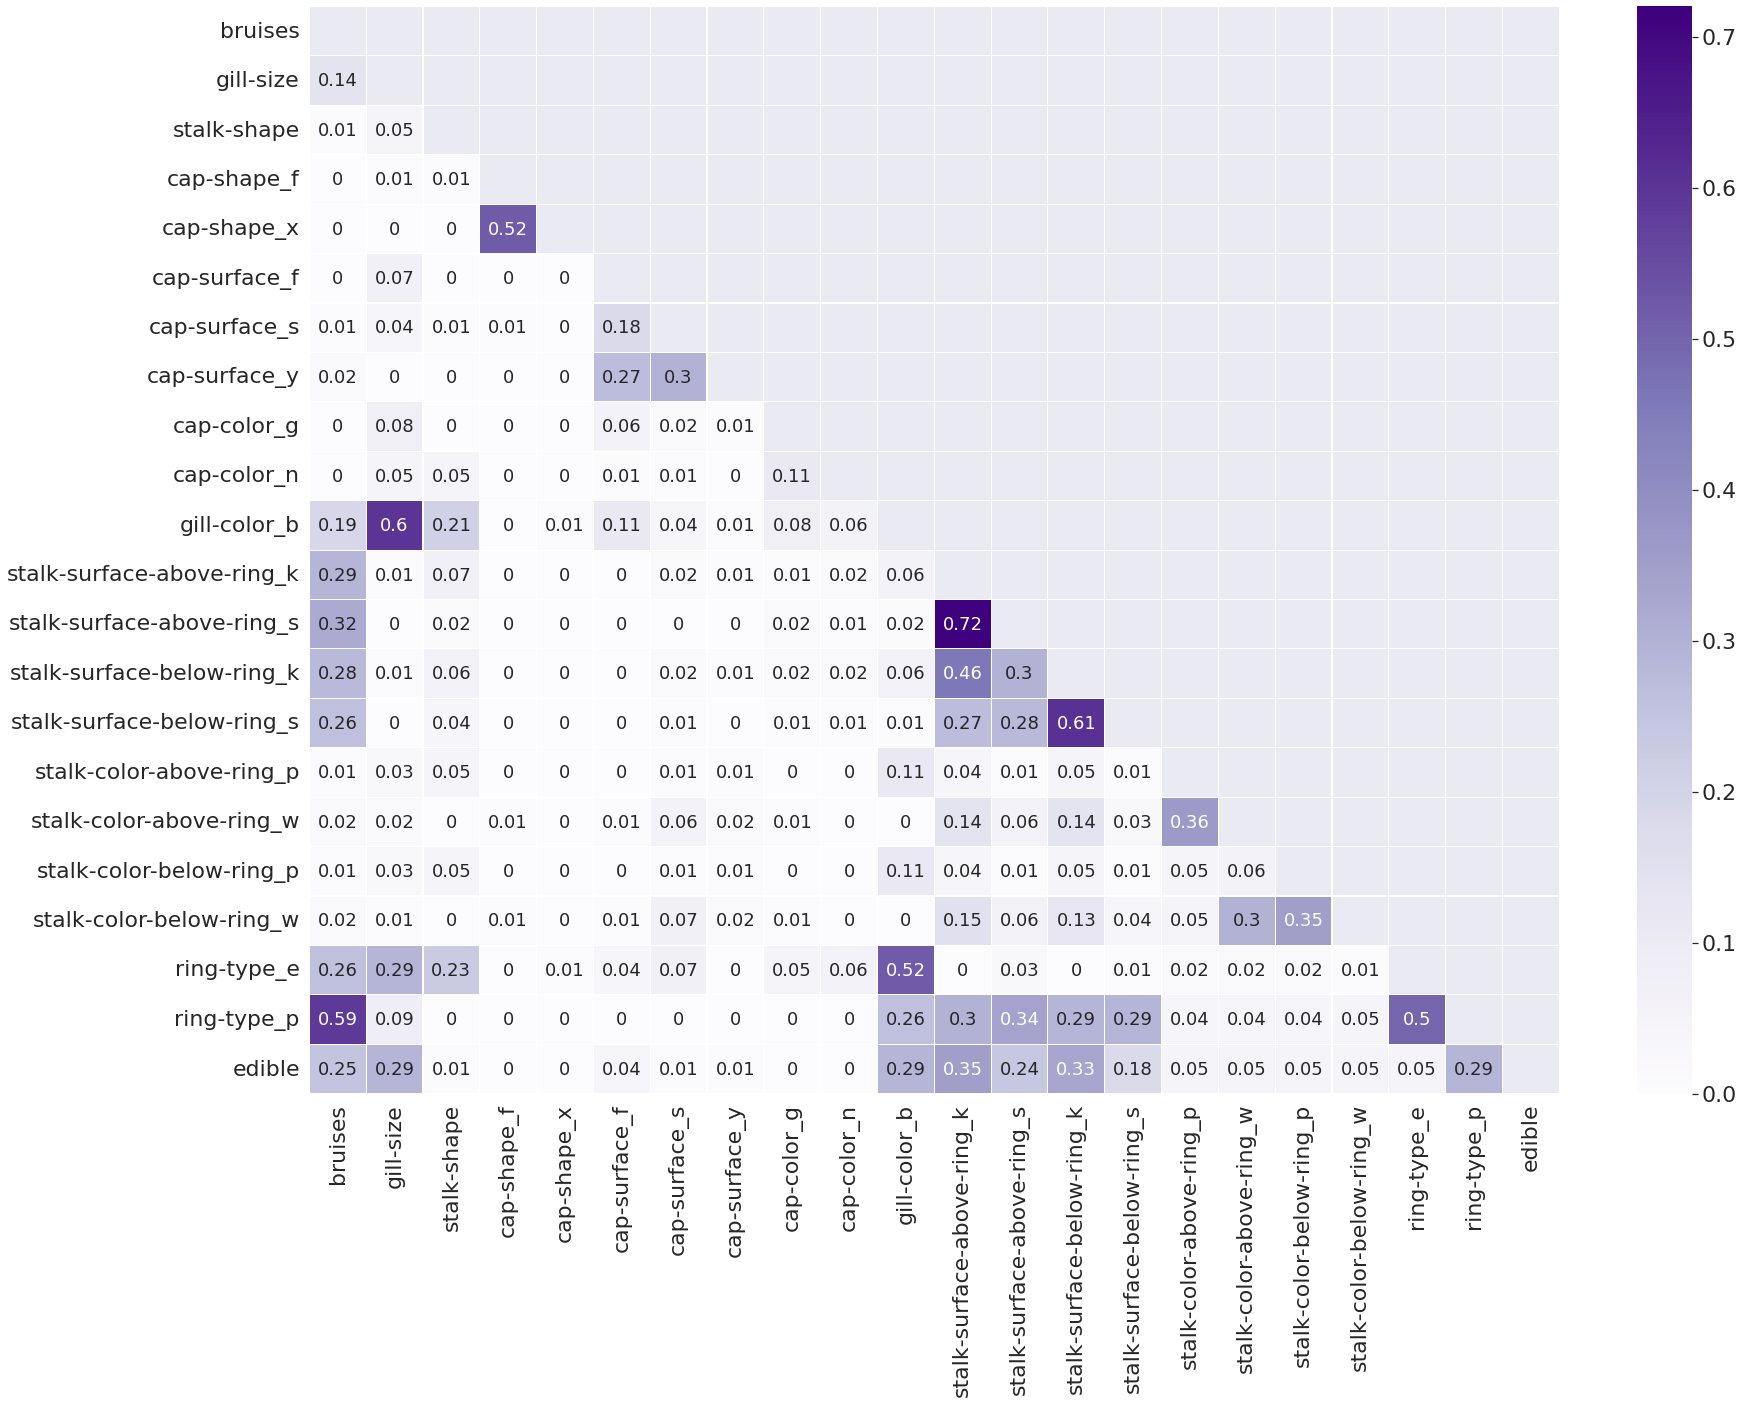

In [153]:
sns.set()
rows = []
sns.set(font_scale=2)
for var1 in df:
    col = []
    for var2 in df:
        cramers =cramers_V(df[var1], df[var2])  # Cramer's V test.
        col.append(round(cramers,2))  # Keeping of the rounded value of the Cramer's V.
    rows.append(col)
  
cramers_results = np.array(rows)
corr = pd.DataFrame(cramers_results, columns=df.columns, index=df.columns)
# Generate a mask for the upper triangle.
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(28, 20))
sns.heatmap(corr,linewidths=.1, mask=mask, cmap="Purples", annot=True, annot_kws={"size": 18})
plt.show()

In order to choose if a pair of attributes were statistically independent or not, it was arbitrarly decided to choose a threshold of 0.5: this means that we will consider only the pairs of features with a correlation of more than 0.5 on the Chramer's V matrix.

In [154]:
correlated_features=['bruises','stalk-surface-above-ring_s','ring-type_e','stalk-surface-below-ring_s','gill-color_b','cap-shape_x']
df=df.drop(correlated_features,1)
print(df.shape)

(8124, 16)


After the preprocessing phase, we ended up with 16 features.

In [155]:
label = df.pop('edible')
X_train, X_test, y_train, y_test2 = \
    train_test_split(
        df, label, stratify=label, test_size=0.2, random_state=42)

In [156]:
params = {
          'alpha': np.arange(0.1,1.1,0.1),
          'fit_prior': [True,False]
         }
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [157]:
cnb = CategoricalNB()
cnbgrid = GridSearchCV(cnb, param_grid = params, 
                                   scoring='accuracy',n_jobs=-1,  
                                   cv=cv, verbose=3).fit(X_train, y_train)
print('\nThe best model selected is:\n{}'.format(cnbgrid.best_estimator_))
report_cv(cnbgrid.cv_results_)

Fitting 30 folds for each of 20 candidates, totalling 600 fits

The best model selected is:
CategoricalNB(alpha=0.1)
Mean validation score: 0.87557 (std: 0.01242)
Parameters: {'alpha': 0.1, 'fit_prior': True}

Mean validation score: 0.87557 (std: 0.01242)
Parameters: {'alpha': 0.2, 'fit_prior': True}

Mean validation score: 0.87557 (std: 0.01242)
Parameters: {'alpha': 0.30000000000000004, 'fit_prior': True}

Mean validation score: 0.87557 (std: 0.01242)
Parameters: {'alpha': 0.4, 'fit_prior': True}

Mean validation score: 0.87557 (std: 0.01242)
Parameters: {'alpha': 0.5, 'fit_prior': True}

Mean validation score: 0.87557 (std: 0.01242)
Parameters: {'alpha': 0.6, 'fit_prior': True}

Mean validation score: 0.87557 (std: 0.01242)
Parameters: {'alpha': 0.7000000000000001, 'fit_prior': True}

Mean validation score: 0.87557 (std: 0.01242)
Parameters: {'alpha': 0.8, 'fit_prior': True}

Mean validation score: 0.87557 (std: 0.01242)
Parameters: {'alpha': 0.9, 'fit_prior': True}

Mean validation

In [158]:
cnb=CategoricalNB(**cnbgrid.best_params_).fit(X_train, y_train)

In [159]:
y_pred_tr = cnb.predict(X_train)

print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average=None))

print(classification_report(y_train, y_pred_tr))
pd.DataFrame(confusion_matrix(y_train, y_pred_tr),
             index = ['class 0 actual', 'class 1 actual'],
             columns = ['class 0 pred', 'class 1 pred'])

Train Accuracy 0.8759809201415603
Train F1-score [0.8593859  0.88907239]
              precision    recall  f1-score   support

           0       0.95      0.79      0.86      3133
           1       0.83      0.96      0.89      3366

    accuracy                           0.88      6499
   macro avg       0.89      0.87      0.87      6499
weighted avg       0.89      0.88      0.87      6499



,class 0 pred,class 1 pred
class 0 actual,2463,670
class 1 actual,136,3230


In [160]:
y_pred = cnb.predict(X_test)
print('Test Accuracy %s' % accuracy_score(y_test2, y_pred))
print('Test F1-score %s' % f1_score(y_test2, y_pred, average=None))

print(classification_report(y_test2, y_pred))
pd.DataFrame(confusion_matrix(y_test2, y_pred),
             index = ['class 0 actual', 'class 1 actual'],
             columns = ['class 0 pred', 'class 1 pred'])

Test Accuracy 0.8904615384615384
Test F1-score [0.87741047 0.90100111]
              precision    recall  f1-score   support

           0       0.95      0.81      0.88       783
           1       0.85      0.96      0.90       842

    accuracy                           0.89      1625
   macro avg       0.90      0.89      0.89      1625
weighted avg       0.90      0.89      0.89      1625



,class 0 pred,class 1 pred
class 0 actual,637,146
class 1 actual,32,810


The preprocessed version of the CategoricalNB on the reduced dataset performs slightly worse than the hyper-parameter tuned one, we infact notice a decrease in the accuracy of the test set from 0.90 to 0.89. We notice no overfitting since our accuracy on the training set is 0.87 and 0.89 on the test set. In terms of recall for class 0 instead, we observe the same performance as the other version of the reduced dataset. However with respect to the preprocessed version on the complete dataset we still have lower performance in terms of accuracy since in the complete version we have a test set accuracy of 0.936; also the recall is lower: 0.88 on the complete version while here we obtained a 0.81. This confirms once again the fact that the removed features on the reduced version were good predictors.

Finally it was decided to manually tune threshold in order to not get errors in the poisonous mushrooms predicted as edible, this means to get a recall of 1 for class 0, however, also in this case, we have a significantly increase in the amount of edible mushrooms classified as poisonous. In this way our model will predict almost everytime a mushroom as poisonous and will be correct approximately half of the times.

In [161]:
yprobcnbprered = cnb.predict_proba(X_test)[:,1]
print("AUC:", round(roc_auc_score(y_test2, yprobcnbprered),2))

AUC: 0.91


In [162]:
th=0.9927
print(classification_report(y_test2, yprobcnbprered>th))
pd.DataFrame(confusion_matrix(y_test2, yprobcnbprered>th),
             index = ['class 0 actual', 'class 1 actual'],
             columns = ['class 0 pred', 'class 1 pred'])

              precision    recall  f1-score   support

           0       0.51      1.00      0.67       783
           1       1.00      0.09      0.17       842

    accuracy                           0.53      1625
   macro avg       0.75      0.55      0.42      1625
weighted avg       0.76      0.53      0.41      1625



,class 0 pred,class 1 pred
class 0 actual,783,0
class 1 actual,764,78


# Models recap

In [163]:
recap_perf_clf = pd.concat([get_metrics_clf(y_test, yprobcnbnopre, th = 0.5, name_col = 'CategoricalNB w/hyper-parameter tuning (complete dataset)'),
                           get_metrics_clf(y_test, yprobcnbpre, th = 0.5, name_col = 'Preprocessed CategoricalNB (complete dataset)'),
                           get_metrics_clf(y_test2, yprobcnbnoprered, th = 0.5, name_col = 'CategoricalNB w/hyper-parameter tuning (reduced dataset)'),
                           get_metrics_clf(y_test2, yprobcnbprered, th = 0.5, name_col = 'Preprocessed CategoricalNB (reduced dataset)'),
                           ], axis = 1).T
recap_perf_clf

,Threshold,Precision,Recall,F1,Accuracy,AUC
CategoricalNB w/hyper-parameter tuning (complete dataset),0.5,0.995,0.932,0.962,0.965,0.999
Preprocessed CategoricalNB (complete dataset),0.5,0.990,0.876,0.930,0.936,0.989
CategoricalNB w/hyper-parameter tuning (reduced dataset),0.5,0.992,0.814,0.894,0.907,0.951
Preprocessed CategoricalNB (reduced dataset),0.5,0.952,0.814,0.877,0.890,0.911


We can observe that, without tuning the threshold, the best version of the CategoricalNB is the one applied on the complete dataset without feature selection and the hyper-parameter tuning: a situation as this one can be expected since the CategoricalNB algorithm assumes statistical indipendence within features but works very well even without removing statistically dependent features; on the other hand a worse performance of the preprocessed version may be due to a low VarianceThreshold feature selection threshold because it seems that possible good predictors may have been removed since we observe a lower performance on both the complete and reduced preprocessed version with respect of not-preprocessed ones.

The following graph shows the ROC curves for each of these 4 models:as we can see the model with the highest ROC auc equal to 0.999 is the hyper-parameter tuned version without feature selection on the complete dataset, while the worst one is the preprocessed version on the reduced dataset with an auc score of 0.911

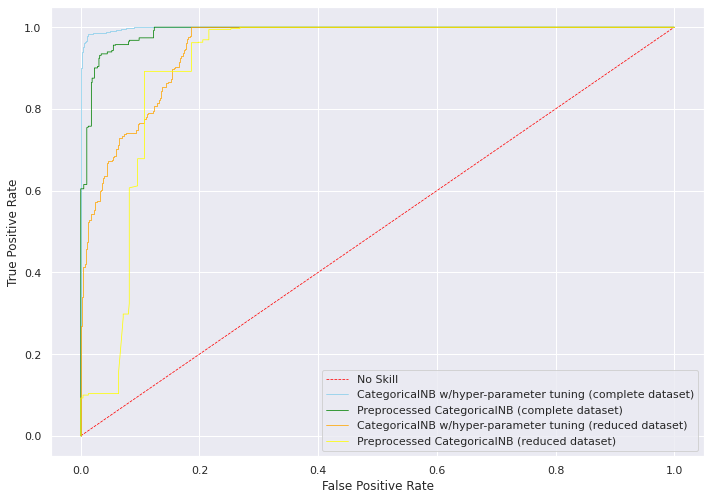

In [164]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
y_probs = [yprobcnbnopre,yprobcnbpre,yprobcnbnoprered,yprobcnbprered]  
# inserire i nomi in ordine rispetto ai predict_proba inseriti
get_roc_curve_plot_new(y_test, y_probs, legend_model=['CategoricalNB w/hyper-parameter tuning (complete dataset)','Preprocessed CategoricalNB (complete dataset)','CategoricalNB w/hyper-parameter tuning (reduced dataset)','Preprocessed CategoricalNB (reduced dataset)'], multiple=True)

In [165]:
def get_metrics_clf(y_test, y_probs, th=0.5, name_col='model'):
    perf = pd.DataFrame(
        [   th,
            np.round(precision_score(y_test, (y_probs > th), pos_label=0), 3),
            np.round(recall_score(y_test, (y_probs > th), pos_label=0), 3),
            np.round(f1_score(y_test, (y_probs > th), pos_label=0), 3),
            np.round(accuracy_score(y_test, (y_probs > th)), 3),
            np.round(roc_auc_score(y_test, y_probs), 3)
        ],
        index=['Threshold','Precision', 'Recall', 'F1', 'Accuracy', 'AUC'],
        columns=[name_col]
    )

    return perf

In [170]:
recap_perf_clf = pd.concat(
    [
        get_metrics_clf(complete_recap['no_fs']['knn'][0], complete_recap['no_fs']['knn'][1], name_col='no_fs knn'),
        get_metrics_clf(complete_recap['no_fs']['svm'][0], complete_recap['no_fs']['svm'][1], name_col='no_fs svm'),
        get_metrics_clf(complete_recap['no_fs']['default_dt'][0], complete_recap['no_fs']['default_dt'][1], name_col='no_fs default'),
        get_metrics_clf(complete_recap['no_fs']['dt'][0], complete_recap['no_fs']['dt'][1], name_col='no_fs dt'),
        get_metrics_clf(complete_recap['no_fs']['default_rf'][0], complete_recap['no_fs']['default_rf'][1], name_col='no_fs default'),
        get_metrics_clf(complete_recap['no_fs']['rf'][0], complete_recap['no_fs']['rf'][1], name_col='no_fs rf'),
        get_metrics_clf(y_test, yprobcnbnopre, th=0.5, name_col='no_fs cnb'),
        get_metrics_clf(complete_recap['fs']['knn'][0], complete_recap['fs']['knn'][1], name_col='fs knn'),
        get_metrics_clf(complete_recap['fs']['svm'][0], complete_recap['fs']['svm'][1], name_col='fs svm'),
        get_metrics_clf(complete_recap['fs']['dt'][0], complete_recap['fs']['dt'][1], name_col='fs dt'),
        get_metrics_clf(complete_recap['fs']['rf'][0], complete_recap['fs']['rf'][1], name_col='fs rf'),
        get_metrics_clf(y_test, yprobcnbpre, th=0.5, name_col='fs cnb')
    ],
    axis=1
)

recap_perf_clf

,no_fs knn,no_fs svm,no_fs default,no_fs dt,no_fs default,no_fs rf,no_fs cnb,fs knn,fs svm,fs dt,fs rf,fs cnb
Threshold,0.5,0.5,0.5,0.5,0.5,0.500,0.500,0.5,0.500,0.500,0.500,0.500
Precision,1.0,1.0,1.0,1.0,1.0,1.000,0.995,1.0,0.932,1.000,1.000,0.990
Recall,1.0,1.0,1.0,1.0,1.0,0.998,0.932,1.0,1.000,0.996,0.996,0.876
F1,1.0,1.0,1.0,1.0,1.0,0.999,0.962,1.0,0.965,0.998,0.998,0.930
Accuracy,1.0,1.0,1.0,1.0,1.0,0.999,0.965,1.0,0.965,0.998,0.998,0.936
AUC,1.0,1.0,1.0,1.0,1.0,0.999,0.999,1.0,0.966,0.998,0.998,0.989


In [171]:
recap_perf_clf = pd.concat(
    [
        get_metrics_clf(reduced_recap['no_fs']['knn'][0], reduced_recap['no_fs']['knn'][1], name_col='no_fs knn'),
        get_metrics_clf(reduced_recap['no_fs']['svm'][0], reduced_recap['no_fs']['svm'][1], name_col='no_fs svm'),
        get_metrics_clf(reduced_recap['no_fs']['default_dt'][0], reduced_recap['no_fs']['default_dt'][1], name_col='no_fs default_dt'),
        get_metrics_clf(reduced_recap['no_fs']['dt'][0], reduced_recap['no_fs']['dt'][1], name_col='no_fs dt'),
        get_metrics_clf(reduced_recap['no_fs']['default_rf'][0], reduced_recap['no_fs']['default_rf'][1], name_col='no_fs default_rf'),
        get_metrics_clf(reduced_recap['no_fs']['rf'][0], reduced_recap['no_fs']['rf'][1], name_col='no_fs rf'),
        get_metrics_clf(y_test2, yprobcnbnoprered, th=0.5, name_col='no_fs cnb'),
        get_metrics_clf(reduced_recap['fs']['knn'][0], reduced_recap['fs']['knn'][1], name_col='fs knn'),
        get_metrics_clf(reduced_recap['fs']['svm'][0], reduced_recap['fs']['svm'][1], name_col='fs svm'),
        get_metrics_clf(reduced_recap['fs']['dt'][0], reduced_recap['fs']['dt'][1], name_col='fs dt'),
        get_metrics_clf(reduced_recap['fs']['rf'][0], reduced_recap['fs']['rf'][1], name_col='fs rf'),
        get_metrics_clf(y_test2, yprobcnbprered, th=0.5, name_col='fs cnb')
    ],
    axis=1
)

recap_perf_clf

,no_fs knn,no_fs svm,no_fs default_dt,no_fs dt,no_fs default_rf,no_fs rf,no_fs cnb,fs knn,fs svm,fs dt,fs rf,fs cnb
Threshold,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500
Precision,0.996,0.997,0.996,0.995,0.999,0.997,0.992,0.979,0.949,0.996,0.996,0.952
Recall,0.996,0.998,0.997,0.995,0.996,0.991,0.814,0.990,0.990,0.996,0.996,0.814
F1,0.996,0.998,0.997,0.995,0.997,0.994,0.894,0.984,0.969,0.996,0.996,0.877
Accuracy,0.996,0.998,0.997,0.995,0.998,0.994,0.907,0.985,0.970,0.996,0.996,0.890
AUC,0.996,0.998,0.997,0.995,0.997,0.994,0.951,0.985,0.970,0.996,0.996,0.911


In [173]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/mzoncheddu/second-midterm


'https://jovian.ai/mzoncheddu/second-midterm'